# **Research Question 1**
#### _"Consider two classifier models, one being a neural network and the other being a variational neural network. How do these models compare in terms of in-sample and out-of-sample error on a poker dataset?"_

## Introduction
The research question above addresses two fundamental problems. The first is the comparison between a neural network (NN) and a variational neural network (vNN) on a dataset. The second is the fact that this dataset is a [poker dataset](http://poker.cs.ualberta.ca/irc_poker_database.html), which is a stochastic dataset, meaning that the dataset contains stochastic / noisy behavior from the poker players and that there is class overlap. Indeed, similar game states can still yield different actions.

As a result, this work will show what happens when a (v)NN-based classifier must train on a stochastic dataset, and will showcase the difference in performance between these two models.

### Literature
**Neural Networks (NNs)** <br>Neural networks are computational models inspired by the structure and function of the human brain (Mitchell, 2007). A neural network consists of interconnected units called neurons that work together to process and learn complex data. The basic structure of a neural network is composed of three main types of layers: input layer, hidden layer(s), and output layer.

 * The input layer receives the input data and passes it to the next layer.
 * The hidden layer(s) perform intermediate computations and apply mathematical transformations to the input data.
 * The output layer produces the final output (i.e. prediction).

Indeed, the input data propagates from the input layer, through the hidden layers, to the output layer. This process is known as forward propagation. It involves calculating the weighted sum at each neuron and applying the activation function of the neuron to the result. Indeed, the neurons are interconnected through weighted connections. The weights represent the strengths of the connections and are adjusted during the training process to improve the output. This process is repeated layer by layer until the output layer is reached. An activation function is a non-linear mathematical function applied to the weighted sum of inputs to a neuron. It introduces non-linearity and enables neural networks to model complex relationships in data. In our models, we will use the Tanh() function as the activation function for each neuron.

To calculate the performance of the neural network during training such as to be able to improve the weights correctly, we must use a loss function. A loss function measures the error between the predicted output and the true output. For this problem, we used the Mean Squared Error (MSE). The act of actually adjusting the weights based on the loss function during training happens through a process called backpropagation. It involves computing the gradient of the loss function with respect to the network's weights, and then updating the weights using an optimization algorithm such as e.g. gradient descent. This iterative process improves the model's performance over time.

Neural networks are very powerful models that can learn complex patterns and make predictions on complex data. 

**Variational Neural Networks (vNNs)** <br>Variational neural networks are a type of neural network that incorporate concepts from variational inference (Oleksiienko, 2022). The goal is to learn probabilistic representations of the data, which would allow for capturing the inherent uncertainty present in the data. During training, a vNN learns a (Gaussian) _probability distribution_ it samples from, rather than a direct output. As a result, the output of the vNN are the predictions of the mean and log-variance of the probability distribution, which are then used to sample this probability distribution and obtain the actual output value for the given input.

Using vNNs seems like a good option here, since we are dealing with a stochastic dataset, and capturing the underlying uncertainty of this dataset would be very beneficial.

### References
* Mitchell, T. M. (2007). Machine learning (Vol. 1). New York: McGraw-hill.
* Oleksiienko, I., Tran, D. T., & Iosifidis, A. (2022). Variational Neural Networks. ArXiv. /abs/2207.01524
* Poker dataset: _[Michael Maurer's IRC Poker Database](http://poker.cs.ualberta.ca/irc_poker_database.html)_

## Imports

In [1]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

## The data

### Pre-processing
The poker data consists of two lists: 
* a list of game states with the form [[private cards], [public cards], [bet history]].
* a list of actions, for each game state, where c = call, r = raise = bet = b, f = fold, k = check.

First, we must pre-process this data such that we work with vectors of bit only. There are 4 rounds: the pre-flop, the flop, the turn, and the river. At the end of all rounds, there have been 7 cards in consideration (2 private cards, 5 public cards). Each card has a rank (there are 13 ranks: 2,3,...K,A), and a suit (there are 4 suits: clubs (♣), diamonds (♦), hearts (♥), and spades (♠)). We convert each rank and each suit to a number, and then convert each number to its binary representation. 

Since for each of the 7 cards, there are 13 ranks (7 * 4 bits), 4 suits (7 * 3 bits), we get 49 bits to represent the cards. For each round, we have a maximum of 4 raises (4 * 3 bits). In total, we get a state vector of 61 bits. The actions are a one-hot encoding of 4 actions (call, raise, fold, check), so the actions are represented by 4 bits. In total, the state-actions of the poker games are represented by a vector of 65 bits.

In [2]:
#======================================#
#=== PREPROCESSING INTO VECTOR DATA ===#
#======================================#

def get_preprocessed_vector_data(preprocessed_readable_data):
    
    print("Preprocessing data into vector form.")
    # Get json converters
    with open('question_1/data/utils/rank2numbr__dataset.json', 'r') as file:
        rank2numbr = json.load(file)
    with open('question_1/data/utils/suit2index__dataset.json', 'r') as file:
        suit2index = json.load(file)

    count_games = 0
    count_states = 0
    preprocessed_vector_data = {}

    for game_id, game in preprocessed_readable_data.items():
        # Pre-process game states
        game_states = game[0]
        preprocessed_game_vector_states = []

        for game_state in game_states:
            # Get state information
            private_cards = game_state[0]
            public_cards = game_state[1]
            raises = game_state[2]
            # Create vector
            cards_vector = get_cards_vector(private_cards, public_cards, 
                                            rank2numbr, suit2index)
            raises_vector = get_raises_vector(raises)
            state = np.array(cards_vector + raises_vector)
            # Store
            preprocessed_game_vector_states.append(state.tolist())
            count_states +=1
        
        # Pre-process game actions
        game_actions = game[1]
        preprocessed_game_vector_actions = []
        action2index = {'c':[1,0,0,0], 'r':[0,1,0,0], 'b':[0,1,0,0], 
                        'f':[0,0,1,0], 'k':[0,0,0,1]}
        for action in game_actions:
            action_idx = action2index[action]
            preprocessed_game_vector_actions.append(action_idx)
        
        # Store states and actions
        preprocessed_vector_data[game_id] = \
            preprocessed_game_vector_states, preprocessed_game_vector_actions

        # Track count
        count_games +=1
        print(f"\rGames processed in vector form: {count_games:,}.", 
              end='')

    print(" (states: {:,}).".format(count_states))
    return preprocessed_vector_data

def get_cards_vector(private_cards, public_cards, 
                     rank2numbr, suit2index, card_format='rs'):
    cards_vector = []
    all_cards = private_cards+public_cards
    for card in all_cards:
        if card_format=='rs':
            rank_binary = number2binarylist(rank2numbr[card[0]], 13)
            suit_binary = number2binarylist(suit2index[card[1]], 4)
        else:
            rank_binary = number2binarylist(rank2numbr[card[1]], 13)
            suit_binary = number2binarylist(suit2index[card[0]], 4)
        cards_vector += rank_binary+suit_binary
    cards_vector += [0]*(49-len(cards_vector))
    return cards_vector

def get_raises_vector(raises):
    raises_vector = []
    for r in raises:
        binary = number2binarylist(r, 4)
        raises_vector += binary
    return raises_vector

def number2binarylist(number, max_number):
    binary_size = len(bin(max_number)[2:])
    binary = bin(number)[2:]
    binary = '0'*(binary_size-len(binary)) + binary
    binary = [int(digit) for digit in binary]
    return binary

In [3]:
#================================#
#=== VARIATIONAL AUTO-ENCODER ===#
#================================#

class VAE(nn.Module):
    def __init__(self, name, input_dim, hidden_dims, latent_dim, loss_type):
        super(VAE, self).__init__()
        self.loss_type = loss_type
        self.name = name

        # Dimensions
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim

        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, dim))
            encoder_layers.append(nn.ReLU())
            prev_dim = dim
        self.encoder = nn.Sequential(*encoder_layers)
        self.fc31 = nn.Linear(prev_dim, latent_dim) # mean
        self.fc32 = nn.Linear(prev_dim, latent_dim) # log variance

        # Decoder
        hidden_dims_reversed = hidden_dims[::-1]
        decoder_layers = []
        prev_dim = latent_dim
        for dim in hidden_dims_reversed:
            decoder_layers.append(nn.Linear(prev_dim, dim))
            decoder_layers.append(nn.ReLU())
            prev_dim = dim
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        h = self.encoder(x)
        return self.fc31(h), self.fc32(h)

    def decode(self, z):
        return self.decoder(z)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def loss_function(self, recon_x, x, z_mean, z_logvar):
        if self.loss_type == "mse":
            loss = F.mse_loss(recon_x, x, reduction='sum')
        elif self.loss_type == "bce":
            loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
        elif self.loss_type == "kl": # KL Divergence
            kl_loss = -0.5 * \
                torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
            loss = kl_loss
        else:
            raise ValueError("Invalid loss type specified.")
        return loss

In [4]:
#===================#
#=== DATA IMPORT ===#
#===================#

def data_import():
    # Import dataset:
    print("\nImporting data ...")
    with open('question_1/data/poker_data__readable.json') as f:
        readable_poker_data = json.load(f)
    poker_data_dict = get_preprocessed_vector_data(readable_poker_data)

    # Store all states and actions:
    print("Storing states and actions ...")
    poker_data = []
    for game_id, game_data in poker_data_dict.items():
        game_states = game_data[0]
        game_actions = game_data[1]
        for i in range(len(game_states)):
            state = game_states[i]
            action = game_actions[i]
            poker_data.append(state+action)

    print("Done.")
    return poker_data

def data_split(split, all_data):
    # Create data split:
    data_fractions = np.cumsum(split)
    split_data = \
        np.split(all_data, (data_fractions[:-1] * len(all_data)).astype(int))
    return all_data, split_data

In [5]:
# Import data
poker_data = data_import()


Importing data ...
Preprocessing data into vector form.
Games processed in vector form: 215,537. (states: 1,024,579).
Storing states and actions ...
Done.


In [6]:
#===================#
#=== ENCODE DATA ===#
#===================#

def encode_data(poker_data):
    # VAE setup
    vae_name = "vae"
    vae_input_state_dim = 61
    vae_hidden_dims = []
    vae_latent_dim = 42
    vae_loss_type = "mse"
    # Instantiate the VAE
    vae = VAE(name=vae_name, 
            input_dim=vae_input_state_dim, 
            hidden_dims=vae_hidden_dims, 
            latent_dim=vae_latent_dim, 
            loss_type=vae_loss_type)
    # Import VAE
    vae.load_state_dict(torch.load("question_1/models/vae.pth"))

    encoded_poker_data = []
    with torch.no_grad():
        for idx, state_action in enumerate(poker_data):
            state = state_action[:vae_input_state_dim]
            action = state_action[vae_input_state_dim:]
            state_tensor = torch.tensor(state, dtype=torch.float)
            action_tensor = torch.tensor(action, dtype=torch.float)
            mu, logvar = vae.encode(state_tensor)
            latent = vae.reparameterize(mu, logvar)

            encoded_poker_data.append(latent.tolist() + action_tensor.tolist())
            print(f"\rEncoding data ({idx+1:,}/{len(poker_data):,}).", end='')
    
    print("\nDone.")
    return encoded_poker_data

In [7]:
# Encode data with VAE
encoded_poker_data = encode_data(poker_data=poker_data)

Encoding data (1,024,579/1,024,579).
Done.


### Stochasticity
Next, we will show that this data is stochastic. The `find_overlaps()` function returns the number of overlaps in the given dataset. We say an overlap occurs when a state has a duplicate somewhere in the dataset, but that state has a different action associated to it.

In [8]:
#====================#
#=== FIND OVERLAP ===#
#====================#

def find_overlaps(state_action_tensor, state_dim):
    # Definitions
    state_tensor = state_action_tensor[:, :state_dim]
    
    # Get duplicate states
    unique_states, inverse_indices, counts = torch.unique(state_tensor, 
                                                        return_inverse=True, 
                                                        return_counts=True,
                                                        dim=0)
    duplicate_states_indices = torch.nonzero(counts > 1).squeeze()
    duplicate_states = unique_states[duplicate_states_indices]

    # Count ALL state overlaps
    overlap_count = 0
    for i,state in enumerate(duplicate_states):
        duplicate_state_indices = torch.nonzero(torch.all(state_tensor == state, dim=1)).squeeze()
        duplicate_state_with_actions = state_action_tensor[duplicate_state_indices, :]

        # Check all states that have a duplicate
        first_state_action = state_action_tensor[duplicate_state_indices[0]]
        equal_state_actions = torch.all(torch.eq(duplicate_state_with_actions, first_state_action), dim=1)
        all_equal = torch.all(equal_state_actions)
        # Check if one of those duplicates has a different action
        if not all_equal:
            # If the selected state has duplicates but with different actions, 
            # that means that this state has a class overlap, so we add them to the count.
            overlap_count += len(duplicate_state_indices.tolist())
        print(f"\rNumber of overlaps found: {overlap_count:,}/{len(state_tensor):,} (Progress: {100*(i+1)/len(duplicate_states):.1f}%).", end='')

    return overlap_count

In [9]:
# Get the number of overlaps in the poker data for similar states
state_dim = 61
rounded_state_action_tensor = torch.round(torch.tensor(poker_data))
overlap_count = find_overlaps(state_action_tensor=rounded_state_action_tensor, 
                              state_dim=state_dim)

Number of overlaps found: 394,737/1,024,579 (Progress: 100.0%).

The computations above show that nearly 40% of all states have a class overlap. This shows that the dataset is very much stochastic due to the nature of the game of poker, and that the classifiers will not be able to achieve high accuracy. The question is, which model will perform better?

## The neural network (NN) classifier

### Definitions
Defining the neural network (NN) model class. The neural network takes as parameters the state dimension (i.e. input dimension), the hidden dimensions, the action dimension (i.e. output dimension), the loss function, and the activation function.

In [10]:
#======================#
#=== NEURAL NETWORK ===#
#======================#

class NN(nn.Module):
    def __init__(self, name, state_dim, hidden_dims, action_dim, 
                 loss_func, activ_func):
        super(NN, self).__init__()
        # store input params:
        self.name = name
        self.input_dim = state_dim
        self.hidden_dims = hidden_dims
        self.latent_dim = action_dim
        self.loss_func = loss_func

        # build generator neural net:
        generator_layers = []
        prev_dim = state_dim
        for dim in hidden_dims:
            generator_layers.append(nn.Linear(prev_dim, dim))
            generator_layers.append(activ_func)
            prev_dim = dim
        generator_layers.append(nn.Linear(prev_dim, action_dim))
        generator_layers.append(nn.Sigmoid())
        self.generator_nn = nn.Sequential(*generator_layers)

    def forward(self, state):
        state = state.to(torch.float)
        action = self.generator_nn(state)
        return action

### Training
First, we define a function that will be used for testing.

In [11]:
#=====================#
#=== TEST FUNCTION ===#
#=====================#

def test_model(model, model_type, data_name, num_tests, test_data, state_dim, final_epoch):
    model.eval()
    if final_epoch: print("")

    # Track label distributions for the model and for the expert
    model_label_distr = np.array([0,0,0,0])
    expert_label_distr = np.array([0,0,0,0])

    # Determine number of tests
    if num_tests == "all":
        num_tests = len(test_data)
    elif num_tests > len(test_data) and len(test_data) != 0:
        num_tests = len(test_data)

    # Perform test
    count_gen = 0
    for i in range(num_tests):
        print(f"\rTesting on {data_name} ({100*(i+1)/num_tests:.1f}%).                   ", end='')
        # Get expert action
        state_action = test_data[i].to(torch.float)
        state = state_action[:state_dim]
        expert_label = state_action[state_dim:].to(torch.int).tolist()
        # Generate action by model
        if model_type == "nn":
            model_action = model(state)
        elif model_type == "vnn":
            model_action, mu, logvar = model(state)
        model_label = to_one_hot(model_action)
        
        # Count correct generated actions
        if expert_label == model_label:
            count_gen +=1
        
        # Update distributions
        model_label_distr += np.array(model_label)
        expert_label_distr += np.array(expert_label)
    
    # Calculate score
    model_score = 100.*count_gen/num_tests
    if final_epoch:
        print(f"\nAccuracy: {model_score:.1f}%, Expert distr: {expert_label_distr}, Model distr: {model_label_distr}", end='')

    return model_score

def to_one_hot(lst):
    # Find the index of the maximum value in the list
    max_index = max(range(len(lst)), key=lst.__getitem__)
    # Create a new list with all zeros except for a 1 at the max index
    one_hot = [0] * len(lst)
    one_hot[max_index] = 1
    return one_hot

Next, we train the NN model. We choose the number of neurons such that the data is about 10 times the number of weights. We only save the model if it beats the all time best model so far in terms of performance on the validation dataset. We specify the learning rate (lr), the batch size, and the weight decay for learning. These parameters have been chosen after a lot of testing and optimizing.

Model size: 86016
Data size: 768434
Data size / Model size: 8.93

Training: Epoch 50/50 (100.0%)                         
Testing on train data (100.0%).                   
Accuracy: 60.6%, Expert distr: [14095 18299     0 18835], Model distr: [12790 19137     0 19302]
Testing on validation data (100.0%).                   
Accuracy: 59.5%, Expert distr: [14089 18683     0 18457], Model distr: [12716 19142     0 19371]

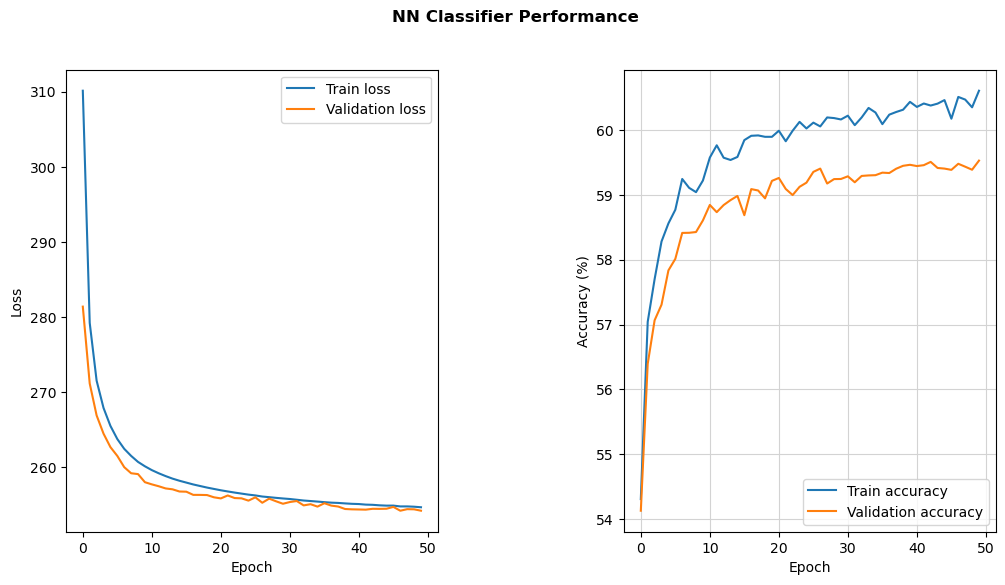

In [12]:
#===================#
#=== NN TRAINING ===#
#===================#

if __name__ == '__main__':
    # Hardware setup
    device = torch.device("cpu")
    
    # Split data
    all_data, [train_data, val_data, test_data] = data_split(all_data=encoded_poker_data,
                                                           split=[0.75, 0.05, 0.2])
    
    # Params
    name = "nn_classifier"
    save = True
    state_dim = 42
    hidden_dims = [64,8]
    action_dim = 4
    lr = 5e-4
    weight_decay = 1e-4
    batch_size = 512
    epochs = 50
    loss_func = nn.MSELoss(reduction='sum')
    activ_func = nn.Tanh()
    
    # Define model
    nn_classifier = NN(name=name, 
                       state_dim=state_dim, 
                       hidden_dims=hidden_dims, 
                       action_dim=action_dim,
                       loss_func=loss_func,
                       activ_func=activ_func)
    
    # Define optimizer
    optimizer = torch.optim.Adam(nn_classifier.parameters(), 
                                 lr=lr, 
                                 weight_decay=weight_decay)
    criterion = loss_func.to(device)
    
    # Print model and data information
    total_dimension = state_dim
    for i in range(len(nn_classifier.generator_nn)):
        if type(nn_classifier.generator_nn[i]) == nn.Linear:
            layer_dimension = len(nn_classifier.generator_nn[i].weight)
            total_dimension *= layer_dimension
    print(f"Model size: {total_dimension}")
    print(f"Data size: {len(train_data)}")
    print(f"Data size / Model size: {len(train_data)/total_dimension:.2f}\n")

    # Load model and data onto device
    nn_classifier = nn_classifier.to(device)
    train_inputs = torch.tensor(train_data[:, :state_dim])
    train_outputs = torch.tensor(train_data[:, state_dim:])
    train_dataset = TensorDataset(train_inputs, train_outputs)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_inputs = torch.tensor(val_data[:, :state_dim])
    val_outputs = torch.tensor(val_data[:, state_dim:])
    val_dataset = TensorDataset(val_inputs, val_outputs)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    # Train the network and plot the performance
    train_losses = []
    val_losses = []
    train_scores = []
    val_scores = []
    num_epochs = epochs

    max_score = 0.0
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_dataloader):
            nn_classifier.train()
            inputs, labels = data
            optimizer.zero_grad()
            train_outputs = nn_classifier(inputs.float())
            train_loss = criterion(train_outputs, labels.float())
            train_loss.backward()
            optimizer.step()

            running_loss += train_loss.item()
            print(f"\rTraining: Epoch {epoch+1}/{epochs} ({100*(i+1)/len(train_dataloader):.1f}%)            ", end='')

        # Compute test loss
        val_loss = 0.0
        with torch.no_grad():
            nn_classifier.eval()
            for i, data in enumerate(val_dataloader):
                inputs, labels = data
                val_outputs = nn_classifier(inputs.float())
                val_loss += criterion(val_outputs, labels.float()).item()

        # Store and print statistics
        train_loss = running_loss / len(train_dataloader)
        val_loss = val_loss / len(val_dataloader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Testing
        final = True if epoch+1 == num_epochs else False
        train_score = test_model(nn_classifier, "nn", "train data", len(val_data), torch.tensor(train_data), state_dim, final)
        val_score = test_model(nn_classifier, "nn", "validation data", len(val_data), torch.tensor(val_data), state_dim, final)
        train_scores.append(train_score)
        val_scores.append(val_score)

        # Save
        if val_score > max_score and save == True:
            # Save max score
            max_score = val_score
            # Save the model
            torch.save(nn_classifier.state_dict(), f'question_1/models/{nn_classifier.name}.pth')

    # Plot performance
    epochs = range(num_epochs)

    plt.figure(figsize=(12, 6))
    plt.suptitle("NN Classifier Performance", fontweight='bold')

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train loss')
    plt.plot(epochs, val_losses, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_scores, label='Train accuracy')
    plt.plot(epochs, val_scores, label='Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.subplots_adjust(wspace=0.5)

    plt.grid(color='lightgrey')
    plt.savefig('question_1/plots/nn_classifier.png')
    plt.show()

## The variational neural network (vNN) classifier

### Definitions
Defining the variational neural network (vNN) model class. The variational neural network takes as parameters the state dimension (i.e. input dimension), the hidden dimensions, the action dimension (i.e. output dimension), the loss function, and the activation function.

In [13]:
#==================================#
#=== VARIATIONAL NEURAL NETWORK ===#
#==================================#

class vNN(nn.Module):
    def __init__(self, name, state_dim, hidden_dims, action_dim, 
                 loss_func, activ_func):
        super(vNN, self).__init__()
        # store input params:
        self.name = name
        self.input_dim = state_dim
        self.hidden_dims = hidden_dims
        self.latent_dim = action_dim
        self.loss_func = loss_func

        # build generator neural net:
        generator_layers = []
        prev_dim = state_dim
        for dim in hidden_dims:
            generator_layers.append(nn.Linear(prev_dim, dim))
            generator_layers.append(activ_func)
            prev_dim = dim
        generator_layers.append(nn.Linear(prev_dim, action_dim))
        generator_layers.append(nn.Sigmoid())
        self.generator_nn = nn.Sequential(*generator_layers)
        self.fc31 = nn.Linear(action_dim, action_dim) # mean
        self.fc32 = nn.Linear(action_dim, action_dim) # log variance

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, state):
        state = state.to(torch.float)
        action = self.generator_nn(state)
        mu = self.fc31(action)
        logvar = self.fc32(action)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

### Training
We train the vNN model. We choose the number of neurons such that the data is about 10 times the number of weights. We only save the model if it beats the all time best model so far in terms of performance on the validation dataset. We specify the learning rate (lr), the batch size, and the weight decay for learning. These parameters have been chosen after a lot of testing and optimizing.

Model size: 86016
Data size: 768434
Data size / Model size: 8.93

Training: Epoch 50/50 (100.0%)                         
Testing on train data (100.0%).                   
Accuracy: 60.4%, Expert distr: [14095 18299     0 18835], Model distr: [12557 19364     0 19308]
Testing on validation data (100.0%).                   
Accuracy: 59.4%, Expert distr: [14089 18683     0 18457], Model distr: [12658 19401     0 19170]

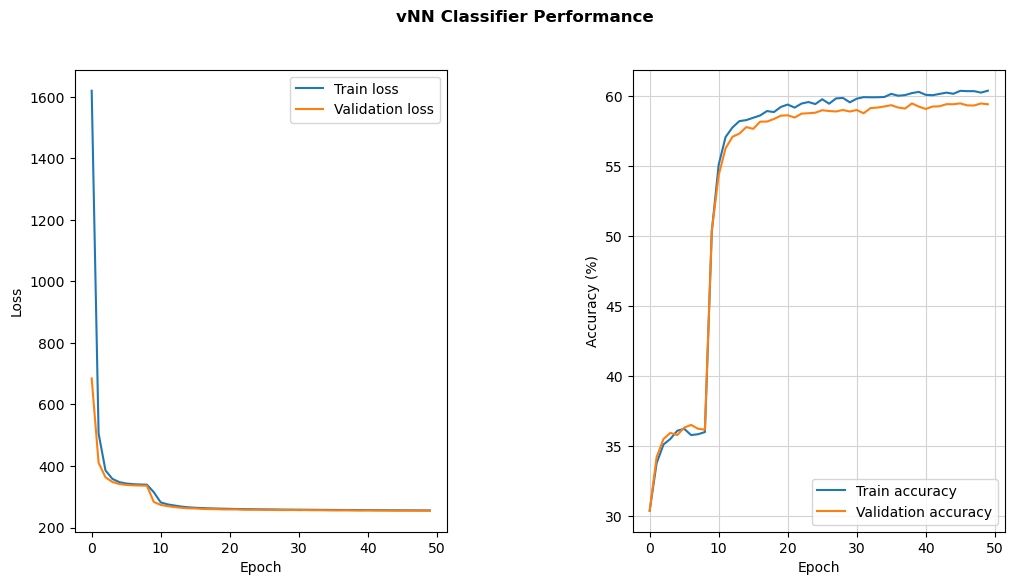

In [14]:
#====================#
#=== vNN TRAINING ===#
#====================#

if __name__ == '__main__':
    # Hardware setup
    device = torch.device("cpu")
    
    # Split data
    all_data, [train_data, val_data, test_data] = data_split(all_data=encoded_poker_data,
                                                           split=[0.75, 0.05, 0.2])
    
    # Params
    name = "vnn_classifier"
    save = True
    state_dim = 42
    hidden_dims = [64,8]
    action_dim = 4
    lr = 5e-4
    weight_decay = 1e-4
    batch_size = 512
    epochs = 50
    loss_func = nn.MSELoss(reduction='sum')
    activ_func = nn.Tanh()
    
    # Define model
    vnn_classifier = vNN(name=name, 
                        state_dim=state_dim, 
                        hidden_dims=hidden_dims, 
                        action_dim=action_dim,
                        loss_func=loss_func,
                        activ_func=activ_func)
    
    # Define optimizer
    optimizer = torch.optim.Adam(vnn_classifier.parameters(), 
                                 lr=lr, 
                                 weight_decay=weight_decay)
    criterion = loss_func.to(device)
    
    # Print model and data information
    total_dimension = state_dim
    for i in range(len(vnn_classifier.generator_nn)):
        if type(vnn_classifier.generator_nn[i]) == nn.Linear:
            layer_dimension = len(vnn_classifier.generator_nn[i].weight)
            total_dimension *= layer_dimension
    print(f"Model size: {total_dimension}")
    print(f"Data size: {len(train_data)}")
    print(f"Data size / Model size: {len(train_data)/total_dimension:.2f}\n")

    # Load model and data onto device
    vnn_classifier = vnn_classifier.to(device)
    train_inputs = torch.tensor(train_data[:, :state_dim])
    train_outputs = torch.tensor(train_data[:, state_dim:])
    train_dataset = TensorDataset(train_inputs, train_outputs)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_inputs = torch.tensor(val_data[:, :state_dim])
    val_outputs = torch.tensor(val_data[:, state_dim:])
    val_dataset = TensorDataset(val_inputs, val_outputs)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    # Train the network and plot the performance
    train_losses = []
    val_losses = []
    train_scores = []
    val_scores = []
    num_epochs = epochs

    max_score = 0.0
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_dataloader):
            vnn_classifier.train()
            inputs, labels = data
            optimizer.zero_grad()
            train_outputs, mu, logvar = vnn_classifier(inputs.float())
            train_loss = criterion(train_outputs, labels.float())
            train_loss.backward()
            optimizer.step()

            running_loss += train_loss.item()
            print(f"\rTraining: Epoch {epoch+1}/{epochs} ({100*(i+1)/len(train_dataloader):.1f}%)            ", end='')

        # Compute test loss
        val_loss = 0.0
        with torch.no_grad():
            vnn_classifier.eval()
            for i, data in enumerate(val_dataloader):
                inputs, labels = data
                val_outputs, _, _ = vnn_classifier(inputs.float())
                val_loss += criterion(val_outputs, labels.float()).item()

        # Store and print statistics
        train_loss = running_loss / len(train_dataloader)
        val_loss = val_loss / len(val_dataloader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Testing
        final = True if epoch+1 == num_epochs else False
        train_score = test_model(vnn_classifier, "vnn", "train data", len(val_data), torch.tensor(train_data), state_dim, final)
        val_score = test_model(vnn_classifier, "vnn", "validation data", len(val_data), torch.tensor(val_data), state_dim, final)
        train_scores.append(train_score)
        val_scores.append(val_score)

        # Save
        if val_score > max_score and save == True:
            # Save max score
            max_score = val_score
            # Save the model
            torch.save(vnn_classifier.state_dict(), f'question_1/models/{vnn_classifier.name}.pth')

    # Plot performance
    epochs = range(num_epochs)

    plt.figure(figsize=(12, 6))
    plt.suptitle("vNN Classifier Performance", fontweight='bold')

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train loss')
    plt.plot(epochs, val_losses, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_scores, label='Train accuracy')
    plt.plot(epochs, val_scores, label='Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.subplots_adjust(wspace=0.5)

    plt.grid(color='lightgrey')
    plt.savefig('question_1/plots/vnn_classifier.png')
    plt.show()

## Testing
We will now test the error and accuracy on the test set.

In [15]:
# Setting the data
test_inputs = torch.tensor(test_data[:, :state_dim])
test_outputs = torch.tensor(test_data[:, state_dim:])
test_dataset = TensorDataset(test_inputs, test_outputs)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [16]:
# Load best saved models
nn_classifier.load_state_dict(torch.load("question_1/models/nn_classifier.pth"))
vnn_classifier.load_state_dict(torch.load("question_1/models/vnn_classifier.pth"))

<All keys matched successfully>

### Test of the NN classifier

In [17]:
# Compute test loss
nn_test_loss = 0.0
with torch.no_grad():
    nn_classifier.eval()
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        test_outputs = nn_classifier(inputs.float())
        nn_test_loss += criterion(test_outputs, labels.float()).item()

print(f"NN model: test loss = {nn_test_loss:.1f}")

NN model: test loss = 104302.0


In [18]:
# Compute test accuracy
nn_test_score = test_model(nn_classifier, "nn", "test data", len(test_data), torch.tensor(test_data), state_dim, True)
print(f"\nNN model: test accuracy = {nn_test_score:.1f}%.")


Testing on test data (100.0%).                   
Accuracy: 58.6%, Expert distr: [58456 76839     0 69621], Model distr: [53322 79454     0 72140]
NN model: test accuracy = 58.6%.


### Test of the vNN classifier

In [19]:
# Compute test score
vnn_test_loss = 0.0
with torch.no_grad():
    vnn_classifier.eval()
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        test_outputs, _, _ = vnn_classifier(inputs.float())
        vnn_test_loss += criterion(test_outputs, labels.float()).item()

print(f"vNN model: test loss = {vnn_test_loss:.1f}")

vNN model: test loss = 104714.7


In [20]:
# Compute test accuracy
vnn_test_score = test_model(vnn_classifier, "vnn", "test data", len(test_data), torch.tensor(test_data), state_dim, True)
print(f"\nvNN model: test accuracy = {vnn_test_score:.1f}%.")


Testing on test data (100.0%).                   
Accuracy: 58.4%, Expert distr: [58456 76839     0 69621], Model distr: [53417 82037     0 69462]
vNN model: test accuracy = 58.4%.


### Comparison

In [24]:
# Calculate differences
loss_difference = 100 * nn_test_loss / vnn_test_loss
score_difference = 100 * nn_test_score / vnn_test_score

print(f"The NN has a {100-loss_difference:.2f}% lower loss.")
print(f"The NN has a {score_difference-100:.2f}% higher accuracy.")

The NN has a 0.39% lower loss.
The NN has a 0.25% higher accuracy.


## Conclusion
Our goal was to find out how well a NN classifier and a vNN classifier can learn a stochastic dataset such as a poker dataset, and which model is best.

In terms of how well these models learn the data, both barely manage to reach 60% accuracy on the training set, and seem to plateau at this value. The models hit accuracies on the validation set and test set that are close to 60%, indicating that these models are most likely not overfitting. The results also show that the models seem to learn the distribution of actions well, with an appropriate proportion of call, raises, folds, and checks w.r.t. the experts in the dataset. This project was meant to include the performance on a poker engine, however, it was not possible to include this inside the notebook without cluttering the codebase with massive amounts of code. However, the tests were performed outside this notebook, and show that these models actually play poker very well. They beat a random poker agent by over 2000mbb/h, which is huge considering the fact that professional players consider that beating an opponent by 200mbb/h is significant. To conclude on the learning ability of both models, the accuracy seems low due to the stochastic nature of the dataset causing class overlaps, but the actual performance in poker games is good, meaning that the models do learn the poker data to a significant extent.

The next aspect to assess is which model performs best between the two. Based on the results above, the NN classifier performs very slightly better than the vNN classifier. However, the difference is extremely small, at less than 1% for both loss and accuracy, meaning there is no strong conclusion on which model is best in terms of performance, and both models should be considered equivalent on that front. A more noticable difference, however, is the difference in learning speeds. The NN classifier converges significantly faster than the vNN classifier for the same parameters and the same epochs. For instance, the plots below show that the NN requires 1 epoch to reach 55% accuracy, while the vNN requires 10 epochs to do so.

<br>

![NN performance](question_1/plots/nn_classifier.png)
![vNN performance](question_1/plots/vnn_classifier.png)

# **Research Question 2**
#### _"Do Specialized Models Outperform a General 'One Model Fits All' Approach in Predictive Analysis?"_

## Intoduction
Many fields have seen substantial benefit from the application of machine learning techniques and the construction of predictive models,including finance, retail and even space exploration to name a few.
For example, in the financial sector predictive models have been instrumental in assisting banks in credit scoring , investment strategies and fraud detection.<br>
The choise of models and machine learning training strategies is crutial to build robust models that can generalize well and deliver the best performance. <br>
However,the optimal strategy for generalization in machine learning remains a contested topic devoid of clear consensus. <br>
Some argue that building a unique specialized model for each task leads to superior performance , while others maintain the belief that generalized models offer a more efficient and robust solution and these models are usually more flexiable and scalable. <br>

In this notebook i plan to systematically investigate these two approaches (generalized vs specialized) and determine which one is more viable under diverce conditions.<br>
This work will not only be benifial for machine learning practitioners but also will help decision-makers across multiple industries. <br>


In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from pycaret.datasets import get_data
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import label_binarize
from joblib import Parallel, delayed
import multiprocessing
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Requirements  :
# !pip install numpy
# !pip install lightgbm
# !pip install pandas
# !pip install scikit-learn
# !pip install pycaret
# !pip install scipy
# !pip install catboost
# !pip install tqdm
# !pip install matplotlib
# !pip install seaborn
# !pip install joblib
# !pip install scipy





### Data preparation and Exploration


<u>Datasets</u> : <br>
Throughout this investigation i will be considering various real-life datasets from different industries.<br> It's essential to  highlight the versatility of each predictive modeling approach on multiple datasets to draw better conclusions about its performance. Each dataset is unique, having its own specific features, intricacies, and industry-specific knowledge, thus presenting a distinct set of challenges for each approach.
<br>
- credit : This dataset contains credit-related information about different customers and whether they have defaulted on their credit or not.
- telescope : This dataset contains data from astronomical observations that aim to help classify high energy Gamma particles in atmosphere.
- bank : This dataset includes information about bank clients and their banking behavior which will indicate indicate whether a client has made a deposit or not.
- diamond : This dataset is about the characteristics of diamonds such as apparence, clarity etc which will be essential in determining their quality.
- wine : This datasets contains multiple information about the chemical properties of wine and its type (red, white etc).


In [ ]:
classification_datasets = {
    'credit': 'default',
    'telescope': 'Class',
    'bank': 'deposit',
    'income': 'income >50K',
    'wine': 'type',
}

In [ ]:
Experiement_datasets = pd.DataFrame(list(classification_datasets.items()), columns=['Dataset', 'Target'])
Experiement_datasets

,Dataset,Target
0,credit,default
1,telescope,Class
2,bank,deposit
3,income,income >50K
4,wine,type


In [ ]:
#check wether a column is numerical or not in a pandas dataframe
def is_number(series):
  return pd.api.types.is_numeric_dtype(series)

#This functions loads the datafra from pycaret library,performs some preprocessing and returns the data(X,y) 
# and some metadata information (numerical/ categorical columns)

# preprocessing:
# drop any row that contains an null in the corresponding target row
# if the dataset target is not in the numerical form then use the label encoder to fix this issue

def load_dataset(dataset_name):
  """Get dataset."""
  target_name = classification_datasets[dataset_name]
  df = get_data(dataset_name, verbose=False).dropna(subset=[target_name])
  X, y = df.drop(target_name, axis=1), df[target_name]
  num_features = X.columns[X.apply(is_number)].tolist()
  cat_features = [c for c in X.columns if c not in num_features]
  n_classes = len(set(y))
  X.loc[:, cat_features] = X.loc[:, cat_features].fillna("NULL")

  # Convert y to numerical form
  le = LabelEncoder()
  y = le.fit_transform(y)
  y = pd.Series(le.fit_transform(y), index=X.index)


  return X, y, num_features, cat_features, n_classes

In [ ]:
dataset_summary = pd.DataFrame(columns=["dataset_name", "num_rows", "num_coulmns","num_classes"])

for index, row in Experiement_datasets.iterrows():
  dataset_name = row['Dataset']
  target_variable = row['Target']
  X, y, _, _, _ = load_dataset(dataset_name)
    
  dataset_summary = dataset_summary.append(pd.Series(
    data=[dataset_name, X.shape[0], X.shape[1], len(set(y))],
    index=dataset_summary.columns
  ),ignore_index=True)
    
dataset_summary

,dataset_name,num_rows,num_coulmns,num_classes
0,credit,24000,23,2
1,telescope,19020,10,2
2,bank,45211,16,2
3,income,32561,13,2
4,wine,6497,12,2


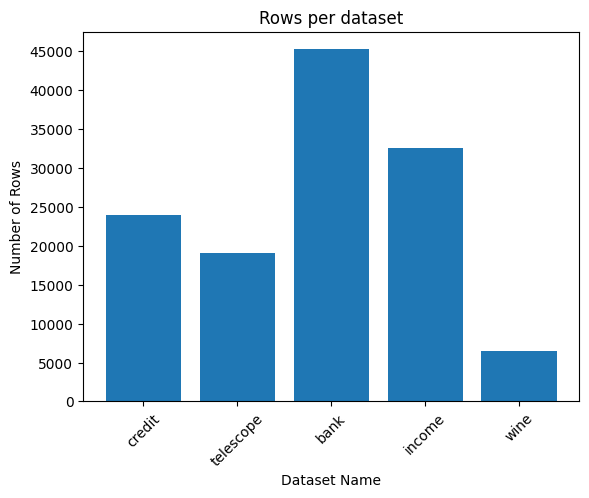

In [ ]:
plt.bar(dataset_summary["dataset_name"], dataset_summary["num_rows"])
plt.xlabel('Dataset Name')
plt.ylabel('Number of Rows')
plt.title('Rows per dataset')
plt.xticks(rotation=45)  
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MultipleLocator(5000))

plt.show()

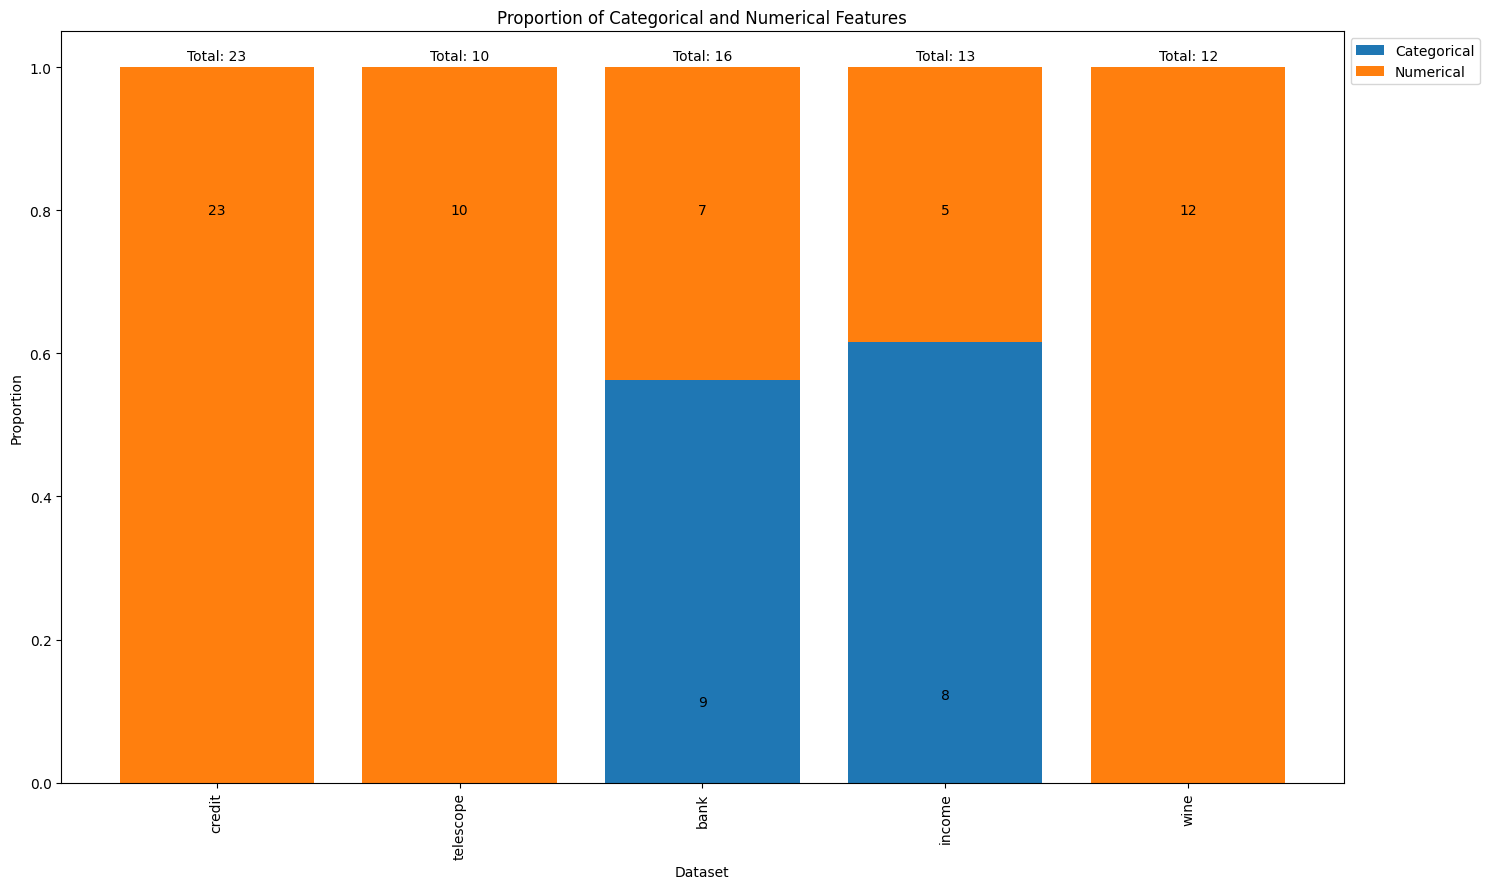

In [ ]:

# Create empty lists to store proportions and total features
categorical_proportions = []
numerical_proportions = []
total_features = []
categorical_counts = []
numerical_counts = []
dataset_names = []

# Iterate over each dataset
for index, row in Experiement_datasets.iterrows():
    dataset_name = row['Dataset']
    target_variable = row['Target']
    
    df = get_data(dataset_name, verbose=False)
    categorical_columns = df.select_dtypes(include='object').columns.tolist()
    numerical_columns = df.select_dtypes(exclude='object').columns.tolist()

    # Remove the target variable from the appropriate column list
    if target_variable in categorical_columns:
        categorical_columns.remove(target_variable)
    elif target_variable in numerical_columns:
        numerical_columns.remove(target_variable)
    
    # Calculate the proportions and counts
    categorical_proportion = len(categorical_columns) / (len(categorical_columns) + len(numerical_columns))
    numerical_proportion = len(numerical_columns) / (len(categorical_columns) + len(numerical_columns))
    categorical_count = len(categorical_columns)
    numerical_count = len(numerical_columns)
    
    # Append the proportions, total features, and dataset name to the lists
    categorical_proportions.append(categorical_proportion)
    numerical_proportions.append(numerical_proportion)
    total_features.append(len(categorical_columns) + len(numerical_columns))
    categorical_counts.append(categorical_count)
    numerical_counts.append(numerical_count)
    dataset_names.append(dataset_name)

# Plot the histogram
plt.figure(figsize=(15, 9))
plt.bar(dataset_names, categorical_proportions, label='Categorical')
plt.bar(dataset_names, numerical_proportions, bottom=categorical_proportions, label='Numerical')
plt.xlabel('Dataset')
plt.ylabel('Proportion')
plt.title('Proportion of Categorical and Numerical Features')
plt.xticks(rotation=90)

# Add counts on the bars
for i in range(len(dataset_names)):
    x = i
    y = categorical_proportions[i]
    if categorical_counts[i] > 0:
        plt.text(x, y / 5, f'{categorical_counts[i]}', ha='center', va='center')
    
    x = i
    y = categorical_proportions[i] + numerical_proportions[i]
    if numerical_counts[i] > 0:
        plt.text(x, 4*y / 5, f'{numerical_counts[i]}', ha='center', va='center')
    
    # Add total features as text above the bars
    plt.text(i, categorical_proportions[i] + numerical_proportions[i] + 0.01, f'Total: {total_features[i]}', ha='center')


# Reposition the legend outside the plot
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()


### Data preprocessing

##### Datasets contain both numerical and categorical features:

since we plan to compare the performance of general models vs specialized models, we have to use multiple datasets.<br>

these datasets however contain both numerical and categorical columns so we need a strategy to deal with this issue ,hence it makes sence to implement binning as part of our data preprocessing.<br>
By transforming numerical features into binned categorical features, we can create a more consistent and uniform input structure across different datasets which is vital for this experiment to work.<br>
Binning also helps when it comes to dealing with non-linear relationships between the features and the target variable, which should make it easier for both general and specialized models to capture these relationships. 

Ideally in the real world, this task takes a lot of time and has to be done by qualified data scientists while performing data exploration / analysis to determine the best features and then deal with each data type accordingly.<br>
However in the context of this experiment although may not be ideal, it helps create an automatic and systematic framework for across all datasets and does a decent job at this task. <br>

One possiblity natural follow-up related to binning is how many bins should we use ? <br>
- This where using the elbow-method is really useful as it will help us of determine the optimal number of bins for each dataset and allows us to balance the complexity and interpretability of our data therefore accommodating the inherent variability among different datasets. This approach enables us to maintain the diversity of our datasets while providing a uniform framework for model comparison.

In [ ]:

def calculate_wcss(binned_col_2d, nbins):
    """Calculate the within-cluster sum of squares (WCSS) for KMeans clustering."""
    kmeans = KMeans(n_clusters=nbins, random_state=0).fit(binned_col_2d)
    return kmeans.inertia_

# the elbow method is a method that is traditionally used for unsupervised learning problems specifically clustering.It helps us
# determine the optimal number of clusters.
# the basic idea is to keep adding more bins until the added complexity (additional bins ) 
# do not significantly improve the kmeans models performance
def elbow_method(wcss_list):
    """Find the optimal number of bins using the elbow method."""
    dist_points_from_line = []

    for i in range(len(wcss_list)):
        x = i + 2
        y = wcss_list[i]
        x1, y1 = 2, wcss_list[0]
        x2, y2 = len(wcss_list) + 1, wcss_list[-1]

        numerator = abs((y2 - y1) * x - (x2 - x1) * y + x2 * y1 - y2 * x1)
        denominator = np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
        dist_points_from_line.append(numerator / denominator)

    return dist_points_from_line.index(max(dist_points_from_line)) + 2

def binnize(col, max_bins=10):
    """Bin numeric values into discrete intervals with the optimal number of bins using the elbow method."""
    wcss_list = []

    for nbins in range(2, max_bins + 1):
        # Compute the quantiles based on the desired number of bins
        bins = np.linspace(0, 1, nbins + 1)
        quantiles = col.quantile(bins).tolist()

        # Make sure the first bin includes the minimum value
        quantiles[0] -= 1e-10
        quantiles = sorted(set(quantiles))

        # Cut the data into bins based on the quantiles
        binned_col = pd.cut(col, bins=quantiles, include_lowest=True, labels=False)

        # Convert binned data into a 2D array for KMeans clustering
        binned_col_2d = np.array(binned_col).reshape(-1, 1)

        # Calculate the within-cluster sum of squares (WCSS)
        wcss_list.append(calculate_wcss(binned_col_2d, nbins))

    # Find the optimal number of bins using the elbow method
    best_nbins = elbow_method(wcss_list)

    # Use the best number of bins to create the final binned data
    best_bins = np.linspace(0, 1, best_nbins + 1)
    best_quantiles = col.quantile(best_bins).tolist()
    best_quantiles[0] -= 1e-10
    best_quantiles = sorted(set(best_quantiles))
    binned_col_optimal = pd.cut(col, bins=best_quantiles, include_lowest=True)

    return binned_col_optimal


# if a dataframe contains numerical features then transform them into categorical features using binning
def process_numerical_features(data, numerical_features):
    # transform numerical coulmns into categorical columns using binning
    X_transformed = data.copy()
    X_transformed.loc[:, numerical_features] = X_transformed.loc[:, numerical_features].fillna(X_transformed.loc[:, numerical_features].median()).apply(lambda col: col if col.nunique() <= 5 else binnize(col)).astype(str)
    return X_transformed


##### Features selection (for specialized models)

Identifying the best features is a crutial step for training the specialized models because these features essentially define the segments on which the specialized models are trained.
<br>
The biggest argument for specialized models is that once we identify which features are most likely to be relevent for predicting the target variable,we can train specialized models that excel on utilizing those features and get the optimal results.
<br>
For example, if we are working on a dataset that includes information from multiple countries, identifying the 'country' feature as a crucial feature can lead to improved model performance since this will allow us to create a specialized model for each country (The idea is that this specialized model will be tailored to leverage the unique patterns and characteristics of the data for each specific country and hence better performance)

For instance , let's say we are trying to predict the credit default rates.
it's not unresonable to assume that the economic and cultural factors make the patterns of default different in each country.

<br>
<br>
This is why we need to focus on the most relevant features (ones that have a statistical dependence with the target variable) to create more meaningful and diverse segments which in turn can lead to better performing specialized models.

<br> Important Note : If we were to choose irrelevant features, the resulting segments might not reflect any distinct patterns related to the target variable, and as a result, our specialized models might not provide any advantage over the general model.

- This is exactly why the careful selection of these dependent features is key to maximizing the potential of this segmented modeling approach.

In [ ]:
def chi_square_test_of_independence(col, target):
    """Perform chi square test between the column and the target then return the p-value.
    p-value informs us whether such an association is statistically significant"""

    #null hypothesis = there is no association between the variables
    crosstab = pd.crosstab(col, target)
    chi2, pvalue, dof, expected = chi2_contingency(crosstab, correction=False)
    return pvalue



def cramers_v(col, target):
    """Calculate Cramer's V coefficient for two categorical arrays.
    cramer's V is a measure of the strength of association between two categorical variables ranging from [0 to 1]"""
    confusion_matrix = pd.crosstab(col, target)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def get_dependent_columns(categorical_data, target, significance_level=0.05, cramer_threshold=0.1):
    """Get the list of columns of categorical_data that are not independent from the target."""
    pvalues = categorical_data.apply(lambda col: chi_square_test_of_independence(col, target))
    v_values = categorical_data.apply(lambda col: cramers_v(col, target))
    dependent_columns = pvalues[(pvalues<significance_level) & (v_values>cramer_threshold)].index.to_list()
    
    return dependent_columns



def select_candidate_values(category_data, target, train_indices, test_indices, segmentation_col, class_count):
    test_value_counts = category_data.loc[test_indices, segmentation_col].value_counts()
    train_unique_values = target.loc[train_indices].groupby(category_data.loc[train_indices, segmentation_col]).nunique()
    test_unique_values = target.loc[test_indices].groupby(category_data.loc[test_indices, segmentation_col]).nunique()

    slection_critiria = (test_value_counts >= 100) & (test_value_counts / len(test_indices) < .5) & (train_unique_values == class_count) & (test_unique_values == class_count)
    selected_values = test_value_counts[slection_critiria].index.to_list()
    
    return selected_values

When we segment data, it's essential to consider several crucial criteria. <br>

- our data segments have to be representative; they have to reflect the diversity and frequency of the categories in the dataset. In my function select_candidate_values, the rule that each category must appears at least 100 times in the test set should help us achieve this representativeness. Although the number 100 is really arbitrary, it's a start to ensure that the segements are not too small.

<br>
<br>


- the association between the categories and the target variable has to be statistically significant. As explained earlier, for this task I will be perform a Chi-square test using the function chi_square_test_of_independence and then filter down to only the columns where the p-value of the test is below a certain significance level (0.05 is the most natural choise). This is done in the select_candidate_values function.
<br>
<br>
- The strength of the association between the categories and our target variable is extremely important, since it helps indicate the predictive power of the categories. For this task, I calculate Cramer's V values and then only select columns whose Cramer's V value exceeds a certain threshold. As a default value for this treshold,i chose 0.1,which can theoritacally guarantee that there is a minor association between the selected categories and the target.I could have been stricter and set the threshold higher but i decided not to do so since i have prepared some other tests later in the experiment to detect if the results that i get are not stastically significant.
<br>
<br>
- in our segments there can't be no single category that overly dominates by making up more than 50% of the test set and also all categories have to be represented to a certain extend (asking for balanced segments is not the correct approach since similar to decision trees the segements don't have to be balanced)
<br>
<br>
By carefully considering these factors, we can construct a systematic segmentation strategy that is statistically sound , doess offer good predictive power, and is relevant and useful in practice.




### Model Training

-For this experiement it's really important to choose machine learning algorithms that can handle categorical data well due to the nature of the data in this experiment.



<u>CatBoost</u>:

CatBoost is a tree based gradient boosting algorithm that works really well with all data types (numerical, categorical, and even text) without extensive prior pre-processing. It's espicially known, for its excelent performance when dealing with categorical features, hence the name catboost.
it uses a different approach than the traditional one-hot-encoding (which can hugely increase the dimentionality of the data by creating a new column for each unique category of a categorical feature) or target based encoding (where we encode each unique category of a categorical feature based on the average of the target corresponding to that category. This approach can be a source of data leakagev and often can lead to overfitting).<br>
Catboost combines both these approaches to create a new method called "Ordered target encoding" which works by calculating the encoded value of each category based on the mean of the target variable up to the given instance in an ordered manner ( where each row's encoding is calculated only from rows before it in the sequence. This way , data leakage is prevented and performance is much more robust)

<br>
Similar to most boosting algorithms catboost creates an ensemble of decision trees , where,sequentially, each newly created tree attempts to correct the errors madde by the privous trees and therefore improving the accuracy each time.
<br>
<br>
<u> Catboost algorithm simplified : </u> <br>
1- The model is initialized with a simple prediction (the mean or simply a constant).<br>
2- The residuals are computed ( residuals = true target - predicted value) <br>
3- A new special type of decision trees called "oblivious trees" (a symmetric tree where all the paths to the leaves have the same length, and each level of the tree corresponds to a decision rule on the same feature for all instances. This reduces the parameters that have to be learned as opposed to regular trees)  is built to predict the residuals (not the actual target). The structure of the tree is determined by selecting splits that minimize the loss function. <br>
4- the predictions are updated =  [the newly predicted residuals *  learning rate + the previous predictions  ]  <br>
5- steps 2-5 are repeated . Each new iteration, a new tree is created to predict the residuals of the current prediction. <br>


<u> Catboost most important parameters : </u> <br>

- Learning rate : controls the speed of learning.
- Depth : Controls the depth of oblivous trees (deeper trees can capture more information by adding more splits but risk overfitting)
- iterations : number of trees in the ensemble .
- l2_leaf_reg : a regularization term to combat overfitting by constraining the model's complexity
- cat_features : one of the most important distingishing features of catboost is its ability to handle categorical data. here we specify a list containing the index of each categorical feature.



<u>LightGBM</u>:
LightGBM is also gradient boosting , tree based algorithm that can is extremely fast and efficient.It's currently one of the best state of the art algorithms and performs constantly well in data-science competitions and the industry. LightGBM also supports both numerical and categorical data (for categorical data further processing might be needed such as one-hot encoding) which makes it a versitile.
<br>
A unique feature of LightGBM, is that unlike its predecessor XGBoost where the decision tree is created using depthwise strategy,LightGBM uses a leaf-wise (best-first) strategy. It does this by choosin the leaf with the maximum loss to grow at each step,. This can potentially result in better accuracy however it's prone to overfitting if not controlled with other parameters.
<br>
<br>
<div style="text-align: center;">
<img src = "https://www.researchgate.net/publication/343566690/figure/fig2/AS:932532258369537@1599344424444/Comparison-between-XGBoost-level-wise-horizontal-tree-growth-and-LightGBM-vertical.png">
</div>

<br>
LightGBM also introduces a new sampling technique known as Gradient-based One-Side Sampling (GOSS).First all the inctances are based on how large their gradients are. Then, GOSS keeps all the instances with large gradients (usualy 20%) and performs random sampling on the instances with small gradients (usually 20% of the remaining 80%). The intuition behind this is that instances with large gradients are harder to learn, which contribute more to the model's learning.
<br>
<br>
<div style="text-align: center;">
<img src="https://i.imgur.com/elUJAZR.png" style="width: 90%; height: 50%;">
</div>

<br>
Similar to most boosting algorithms catboost creates an ensemble of decision trees , where,sequentially, each newly created tree attempts to correct the errors madde by the privous trees and therefore improving the accuracy each time.
<br>
<br>
<u>LightGBM algorithm simplified:</u>

1- Initialize the model with a constant prediction, often the mean of the target.

2- Compute residuals, which are the differences between the true target and current predictions.

3- Build a new tree to predict the residuals, not the target itself. LightGBM uses a leaf-wise growth strategy, selecting the leaf with the maximum delta loss to grow.

4- Update the predictions by adding the newly predicted residuals (multiplied by a learning rate to prevent overfitting) to the previous predictions.

5- Repeat steps 2-4. Each iteration builds a new tree to predict the residuals, which are updated after each iteration.

<u>LightGBM most important parameters:</u>

* learning_rate: Controls the speed of learning.

* num_leaves: This is the main parameter to control the complexity of the tree model.
* max_depth: This parameter specifies the maximum depth to which the tree will grow.
* n_estimators: Number of trees to be built in the ensemble.
* feature_fraction: This parameter specifies the fraction of features to be taken for each tree.
* bagging_fraction and bagging_freq: These parameters are used for bagging to reduce overfitting.
* max_bin: Smaller value of max_bin can save much memory but may slow down the learning process.



In [ ]:
def train_general_model_cat(data, target, categorical_features):
    training_indices, test_indices = train_test_split(data.index, test_size=.25, stratify=target,random_state=0)
    general_model = CatBoostClassifier().fit(X=data.loc[training_indices, :], y=target.loc[training_indices], cat_features=categorical_features, silent=True)
    general_predictions = pd.DataFrame(general_model.predict_proba(data.loc[test_indices, :]), index=test_indices, columns=general_model.classes_)
    return training_indices, test_indices, general_predictions


def train_specialized_model_cat(data, data_categorical, target_data, categorical_features, training_set, test_set, column_for_segmentation, specific_value):
    indices_with_value = data_categorical.loc[data_categorical.loc[:, column_for_segmentation] == specific_value, column_for_segmentation].index    
    specialized_training_indices = list(set(indices_with_value).intersection(training_set))
    specialized_test_indices = list(set(indices_with_value).intersection(test_set)) 

    specialized_model = CatBoostClassifier().fit(X=data.loc[specialized_training_indices, :], 
                                                 y=target_data.loc[specialized_training_indices], 
                                                 cat_features=categorical_features, 
                                                 silent=True)

    specialized_predictions = pd.DataFrame(specialized_model.predict_proba(data.loc[specialized_test_indices, :]), 
                                           index=specialized_test_indices, 
                                           columns=specialized_model.classes_)

    return specialized_test_indices, specialized_predictions


In [ ]:

from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder

def train_general_model_lgbm(data, target, categorical_features):
    data_encoded = pd.get_dummies(data, columns=categorical_features)
    training_indices, test_indices = train_test_split(data_encoded.index, test_size=.25, stratify=target,random_state=0)
    general_model = LGBMClassifier().fit(X=data_encoded.loc[training_indices, :], y=target.loc[training_indices])
    general_predictions = pd.DataFrame(general_model.predict_proba(data_encoded.loc[test_indices, :]), index=test_indices, columns=general_model.classes_)
    return training_indices, test_indices, general_predictions

def train_specialized_model_lgbm(data, data_categorical, target_data, categorical_features, training_set, test_set, column_for_segmentation, specific_value):
    data_encoded = pd.get_dummies(data, columns=categorical_features)
    indices_with_value = data_categorical.loc[data_categorical.loc[:, column_for_segmentation] == specific_value, column_for_segmentation].index
    specialized_training_indices = list(set(indices_with_value).intersection(training_set))
    specialized_test_indices = list(set(indices_with_value).intersection(test_set))

    specialized_model = LGBMClassifier().fit(X=data_encoded.loc[specialized_training_indices, :], 
                                             y=target_data.loc[specialized_training_indices])

    specialized_predictions = pd.DataFrame(specialized_model.predict_proba(data_encoded.loc[specialized_test_indices, :]), 
                                           index=specialized_test_indices, 
                                           columns=specialized_model.classes_)

    return specialized_test_indices, specialized_predictions

### Evaluation metrics

In [ ]:

def get_roc_auc_score(y_true, y_score):
  """Get area under ROC curve.
  ROC Score indicates how well does a model distingish between the target classes
  a perfect classifier has a ROC score of 1
  while a random classifier has a score 0.5
  """
  if y_score.shape[1] == 2:
    return roc_auc_score(y_true, np.array(y_score)[:, 1])
  else:
    # Multi-class problem so we need to use one vs rest approach
    return roc_auc_score(y_true, y_score, multi_class="ovr")
    



### Main Experiement

For each Dataset:
   1. We tranform all numerical columns into categorical
   2. We split it into a train/ test datasets
   3. We train our generalized models on the whole train dataset
   4. On the train dataset we try to find which columns have statistal association with the target variable
   5. We segment our train dataset and test dataset based on those columns
   6. On each segment of the train dataset , we train a specialized model
   7. we evaluate its performance (newly trained specialized model) on the corresponding segment of the test dataset and then also evaluate the performance of the generalized model on the same segment in the test set.
   8. we save the roc_auc score of both the generalized model and specialized models

In [ ]:

def evaluate_candidate(dataset_name,model_specialized_train_func, X, X_cat, y, cat_features, ix_train, ix_test, pred_general, segmentation_column, value):
    ix_test_specialized, pred_specialized = model_specialized_train_func(X, X_cat, y, cat_features, ix_train, ix_test, segmentation_column, value)

    roc_auc_score_general = get_roc_auc_score(y.loc[ix_test_specialized], pred_general.loc[ix_test_specialized, :])
    roc_auc_score_specialized = get_roc_auc_score(y.loc[ix_test_specialized], pred_specialized)

    # Save the actual prediction scores of both models
    pred_general_scores = pred_general.loc[ix_test_specialized, :]
    pred_specialized_scores = pred_specialized

    # Save the true labels
    true_labels = y.loc[ix_test_specialized]

    result = {
        "dataset": dataset_name,
        "column": segmentation_column,
        "value": value,
        "count": len(ix_test_specialized),
        "distr": y.loc[ix_test_specialized].value_counts().to_list(),
        "roc_general": roc_auc_score_general,
        "roc_specialized": roc_auc_score_specialized,
        "pred_general_scores": pred_general_scores,
        "pred_specialized_scores": pred_specialized_scores,
        "true_labels": true_labels,
    }

    return result




def evaluate_dataset(dataset_name,num_cores):
    X, y, numerical_features, categorical_features, n_classes_target = load_dataset(dataset_name)

    train_indices_lgbm, test_indices_lgbm, pred_general_lgbm = train_general_model_lgbm(X, y, categorical_features)
    train_indices_cat, test_indices_cat, pred_general_cat = train_general_model_cat(X, y, categorical_features)

    X_cat = process_numerical_features(X, numerical_features)
    candidate_columns = get_dependent_columns(X_cat, y)

    results_df = pd.DataFrame(columns=["dataset", "column", "value", "count", "distr", "roc_general", "roc_specialized","pred_general_scores","pred_specialized_scores","true_labels"])


    for segmentation_column in candidate_columns:
        candidate_values_lgbm = select_candidate_values(X_cat, y, train_indices_lgbm,test_indices_lgbm, segmentation_column, n_classes_target)
        candidate_values_cat = select_candidate_values(X_cat, y, train_indices_cat,test_indices_cat, segmentation_column, n_classes_target)

        results1 = Parallel(n_jobs=num_cores)(
            delayed(evaluate_candidate)(dataset_name,train_specialized_model_lgbm, X, X_cat, y, categorical_features, train_indices_lgbm, test_indices_lgbm, pred_general_lgbm, segmentation_column, condidate_value) 
            for condidate_value in candidate_values_lgbm)

        results2 = Parallel(n_jobs=num_cores)(
            delayed(evaluate_candidate)(dataset_name,train_specialized_model_cat, X, X_cat, y, categorical_features, train_indices_cat, test_indices_cat, pred_general_cat, segmentation_column, condidate_value) 
            for condidate_value in candidate_values_cat)

        for result in results1 + results2:
            results_df = results_df.append(result, ignore_index=True)

    return results_df

def main():
    dataset_names = Experiement_datasets["Dataset"].values
    num_cores = multiprocessing.cpu_count()

    results = Parallel(n_jobs=num_cores)(
        delayed(evaluate_dataset)(dataset_name,num_cores) for dataset_name in tqdm(dataset_names))
    
    results_df = pd.concat(results, ignore_index=True)

    return results_df


results = pd.DataFrame(columns=["dataset", "column", "value", "count", "distr", "roc_general", "roc_specialized","pred_general_scores","pred_specialized_scores","true_labels"])
results = main()

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
results


,dataset,column,value,count,distr,roc_general,roc_specialized,pred_general_scores,pred_specialized_scores,true_labels
0,credit,LIMIT_BAL,"(190000.0, 240000.0]",806,"[680, 126]",0.770279,0.724761,0 1 16384 0.924376 0.0...,0 1 16384 0.920887 0.0...,16384 0 20481 0 22529 1 22536 0 20...
1,credit,LIMIT_BAL,"(9999.999, 30000.0]",796,"[519, 277]",0.733875,0.704611,0 1 10241 0.855981 0.1...,0 1 10241 0.930374 0.0...,10241 0 2051 1 14340 1 4106 0 14...
2,credit,LIMIT_BAL,"(50000.0, 90000.0]",753,"[536, 217]",0.746815,0.720141,0 1 22530 0.889211 0.1...,0 1 22530 0.905011 0.0...,22530 0 12292 0 2054 0 6154 0 16...
3,credit,LIMIT_BAL,"(240000.0, 340000.0]",745,"[623, 122]",0.728903,0.676447,0 1 12289 0.955589 0.0...,0 1 12289 0.997648 0.0...,12289 0 14339 0 10245 0 18439 0 20...
4,credit,LIMIT_BAL,"(90000.0, 140000.0]",740,"[561, 179]",0.817774,0.779155,0 1 18434 0.942590 0.0...,0 1 18434 0.988685 0.0...,18434 0 12291 0 12293 1 2060 0 14...
...,...,...,...,...,...,...,...,...,...,...
595,wine,quality,"(2.999, 5.0]",558,"[382, 176]",0.999866,0.999955,0 1 4096 0.000037 0.999...,0 1 4096 0.000031 0.999...,4096 1 4101 1 11 0 2068 1 23 ...
596,wine,quality,"(6.0, 9.0]",334,"[266, 68]",1.000000,1.000000,0 1 2048 0.000058 0.999...,0 1 2048 0.000093 0.999...,2048 1 2053 1 7 0 6158 1 6161 ...
597,wine,quality,"(5.0, 6.0]",733,"[577, 156]",0.999722,0.999600,0 1 2054 0.016647 0.983...,0 1 2054 0.005212 0.994...,2054 1 4103 1 6152 1 6153 1 4105 ...
598,wine,quality,"(2.999, 5.0]",558,"[382, 176]",0.999926,0.999881,0 1 4096 0.000396 0.999...,0 1 4096 0.000627 0.999...,4096 1 4101 1 11 0 2068 1 23 ...


In [ ]:
def convert_to_labels(row):
    pred_specialized_labels = row["pred_specialized_scores"].idxmax(axis=1).values
    pred_generalized_labels = row["pred_general_scores"].idxmax(axis=1).values

    true_labels = row["true_labels"].values
    return pd.Series({"pred_specialized_scores": pred_specialized_labels,"pred_general_scores":pred_generalized_labels ,"true_labels": true_labels})


results[["pred_general_scores","pred_specialized_scores","true_labels"]]=results.apply(convert_to_labels, axis=1)

### Result interpretation

The ROC AUC score is a widely used metric in classification tasks which informs us about the performance of a binary classifier. It provides us insight about of how well the model distinguishes between positive and negative samples, with higher scores indicating better classification performance.<br>
However comparing the ROC AUC scores of two models directly may not provide a statistically rigorous comparison (generalized vs specialized models) and this exactly why doing a DeLong test is crutial as it will inform us about wether the observed difference in the ROC scores is statistically significant.<br>
The DeLong test takes into account the correlation between the predictions of the two models and calculates a p-value that indicates the likelihood of observing the observed difference in AUC scores under the null hypothesis of no difference.<br>
We can then easily interpret the result p_value, for example if the p_value is bellow 5% , it's very unlikely that the observed differences in the performance is simply due to sheer luck.


In [ ]:
# I HAVE NOT WRITTEN THIS CODE.
# I HAVE SIMPLY COPIED IT HERE FROM A LIBRARY FOR THE PURPOSE OF GUARANTYING A RIGOROUS SCIENTIFIC ANALYSIS
# code source : https://github.com/yandexdataschool/roc_comparison/blob/master/compare_auc_delong_xu.py

import pandas as pd
import numpy as np
import scipy.stats


def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=float)
    ty = np.empty([k, n], dtype=float)
    tz = np.empty([k, m + n], dtype=float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count


def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)

In [ ]:
def evaluate(results):
  # Transform data to improve clarity

  results["p_value"] = results.apply(lambda row: 
                                      delong_roc_test(row["true_labels"], row["pred_general_scores"], row["pred_specialized_scores"]), 
                                      axis=1)
  
  # If p_value < 0.05, we reject the null hypothesis and consider the difference to be statistically significant
  results["roc_diff_hp"] = results["p_value"].apply(lambda x: "significant" if x < 0.05 else "not significant")
  
  results["compare"] = (results["roc_general"] >= results["roc_specialized"]).map({
    True: "general > specialized",
    False: "specialized > general"
  })

  # Create a DataFrame for significant results
  significant_results = results[results["roc_diff_hp"] == "significant"]

  # Define min and max roc for setting graph limits
  min_roc = significant_results[["roc_general","roc_specialized"]].values.min()
  max_roc = significant_results[["roc_general","roc_specialized"]].values.max()


  # Compute summary statistics
  n_total = len(significant_results)
  n_specialized_better = sum(significant_results["compare"] == "specialized > general")
  n_general_better = sum(significant_results["compare"] == "general > specialized")
  perc_specialized_better = n_specialized_better / n_total * 100
  perc_general_better = n_general_better / n_total * 100

  average_improvement = significant_results.loc[significant_results["compare"] == "specialized > general", "roc_specialized"].mean() - \
                        significant_results.loc[significant_results["compare"] == "specialized > general", "roc_general"].mean()

  average_decrease = significant_results.loc[significant_results["compare"] == "general > specialized", "roc_specialized"].mean() - \
                    significant_results.loc[significant_results["compare"] == "general > specialized", "roc_general"].mean()

  # Print summary statistics
  print(f"Specialized model performs better in {n_specialized_better} out of {n_total} cases ({perc_specialized_better:.1f}%)")
  print(f"General model performs better in {n_general_better} out of {n_total} cases ({perc_general_better:.1f}%)")
  print(f"Average improvement in ROC score when specialized model is better: {average_improvement:.3f}")
  print(f"Average decrease in ROC score when specialized model is worse: {average_decrease:.3f}")


  # Compute the mean difference between the general and specialized models' ROC scores
  mean_difference = (significant_results["roc_general"] - significant_results["roc_specialized"]).mean()

  # Convert to percentage
  mean_difference_percentage = mean_difference * 100

  print(f"The mean difference in ROC scores between the general and specialized models in significant cases is {mean_difference_percentage:.1f}%.")

  # Subplot 1: Pie chart
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

  labels = 'Specialized Better', 'General Better'
  sizes = [n_specialized_better, n_general_better]
  colors = ['#ff9999','#66b3ff']

  ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
  ax1.set_title('Model Performance Comparison For Statistically Significant Cases', fontsize=14)

  #draw circle
  centre_circle = plt.Circle((0,0),0.70,fc='white')
  fig = plt.gcf()
  fig.gca().add_artist(centre_circle)

  # Equal aspect ratio ensures that pie is drawn as a circle.
  ax1.axis('equal')  

  # Subplot 2: Bar chart
  labels = ['Specialized Better', 'General Better']
  roc_difference = [average_improvement, -average_decrease]
  colors = ['#ff9999','#66b3ff']

  ax2.bar(labels, roc_difference, color=colors)
  ax2.set_xlabel('Model Performance', fontsize=14)
  ax2.set_ylabel('Average ROC difference', fontsize=14)
  ax2.set_title('Average ROC score difference', fontsize=14)

  # Set yticks
  max_y = max(roc_difference) + 0.1  # Add a little extra space at the top
  ax2.set_yticks(np.arange(0, max_y, 0.1))

  ax2.grid(True)

  # Display the plot
  plt.tight_layout()
  plt.show()






Specialized model performs better in 61 out of 550 cases (11.1%)
General model performs better in 489 out of 550 cases (88.9%)
Average improvement in ROC score when specialized model is better: 0.004
Average decrease in ROC score when specialized model is worse: -0.020
The mean difference in ROC scores between the general and specialized models in significant cases is 1.7%.


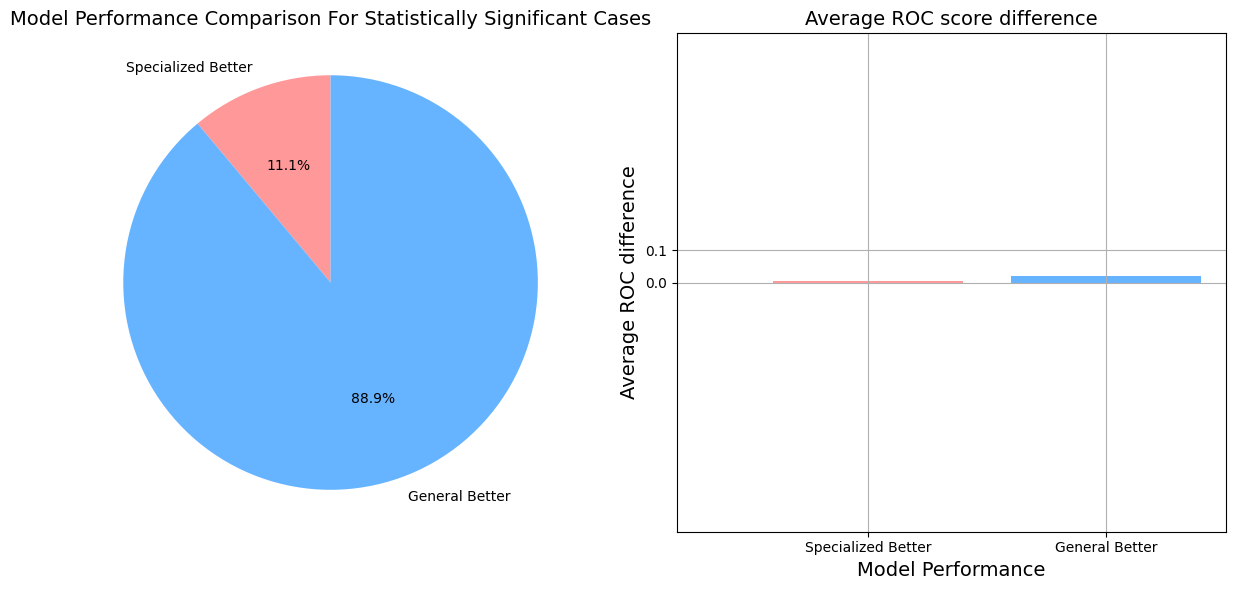

In [ ]:
evaluate(results)

## conclusion

In conclusion, after having tested the performance (ROC_AUC) of 550 machine learning models, using 2 different machine learning algorithms (CatBoost and LGBMBoost) across 5 datasets (from different sectors), It's to assume, that although specialized models can deliver great predictive performance, there's no reason to only focus on this using paradigm and that generalized model do offer robust and comparable and even better performances  most of the time. (88.9%) <br>
In fact, the mean difference in ROC scores between the general and specialized models in significant cases is 1.7% which is  not negligeable.
It's also important to mention that specialized models  :
- can be much harder to maintain espicially when the training data is not static
- can be significantly more complex


## References :

1- CatBoost: gradient boosting with categorical features support
Anna Veronika Dorogush, Vasily Ershov, Andrey Gulin Yandex - http://learningsys.org/nips17/assets/papers/paper_11.pdf

2- LightGBM: A Highly Efficient Gradient Boosting
Decision Tree - https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf

3- CatBoost vs. Light GBM vs. XGBoost : https://medium.com/towards-data-science/catboost-vs-light-gbm-vs-xgboost-5f93620723db

4- Comparison between XGBoost level-wise horizontal tree growth and LightGBM vertical leaf-wist tree growth.
 Available from: https://www.researchgate.net/figure/Comparison-between-XGBoost-level-wise-horizontal-tree-growth-and-LightGBM-vertical_fig2_343566690

5- What is the DeLong test for comparing AUCs? https://statisticaloddsandends.wordpress.com/2020/06/07/what-is-the-delong-test-for-comparing-aucs/ 


# **Research Question 3**
#### _"How does Bayesian Inference for model selection and Bayesian Optimization for hyperparameter tuning impact performance and compare to traditional methods?"_


 
 The traditional methods for model selection in Linear regression are stepwise regression, cross-validation etc. In the first part of this project, I want to see how they compare in accuracy and performance to Bayesian Inference for model selection. 
 I will also explore how Bayesian optimization is used in Support Vector Machines. That is the second part of the project and the dataset for that will be synthetically generated, while for the linear regression model I am using a real dataset.
 
 
 The dataset I choose for linear regression is the Boston Housing dataset available in kaggle.com. It's purpose is to understand which variables drive the price of homes in Boston. As it has only continuous values, it is appropriate for linear regression. Another reason why this is the appropriate dataset is that since the goal is to predict housing prices based on the available data features, then we need to use a  predictive model.
 
 1. First we need to lead the dataset and do all the needed preprocessing.
 2. Then we will develop a linear regression and use Bayesian inference to model selected.
 3. Calculate the mean squared error to see the difference between the estimated values and the actual values, as well as the R-squared error to see how well the model fits the data and some common performance errors  to see how close the model’s predictions are to the true values
 4. Then we will plot the predicted and actual values and see the difference between them.
 5. The same steps will be repeated for cross-validation and stepwise regression. 
 6. From the results we will draw conclusions.
 
 ### Linear regression algorithm explained  explained
 Regression is a form of supervised learning. In supervised learning, we have a lot of data of both the input and the output. Through that we discover connections between the data given as input  and the correct output.
 Linear regression is a form of the linear model were the target function is  a numeric value (continuous)[3]. We say  the form is linear because  the relationship between the dependent variable y and the vector of regressors x is assumed to be linear.[8]
As mentioned in the "Learning from Data"  book, we have an unknown distribution P(x,y) that creates pairs of (x,y) and we want to find a hypothesis that minimizes the error between h(x) and y for the unknown distribution.
 
As stated, the linear regression algorithm is based on minimizing the squared error between h(x) and y2.[7] Where h(x)  contains the predicted values and y is the actual value. All the images of the formulas are taken from the "Learning with Data" book.
 
 ![OutSampleE.png](question_3/data/OutSampleE.png)

In the formula above N is the number of data points, h(x)  contains the predicted values for each input value x and y is the actual value for each data point. Than, we find the difference between h(x) and the  y for every data point n. Than we square this difference, and find  the average for it  across all the data points by summating it and dividing it by the number of data points. This formula represents the out-of-sample error.
 The goal is the find a hypothesis that has a small out-of-sample error. The smaller it is, the more accurate are the predictions of the algorithm. But as the distribution is unknown, we can not compute it. So, we start from the in-sample error.
 ![InSampleE.png](question_3/data/InSampleE.png)
 The formula above is in-sample error, or the training error. The same as the example above: n is data points, h(x) is predicted values and y is real values.
  ![Hypothesis.png](question_3/data/Hypothesis.png)
 From the formula for the hypothesis we understand: xi is one of the features or input, Wi is the weights for the i feature, Wt is the transpose of the vector w and x is the input vector. For the hypothesis, we always want to find the values of the weight vector that best fit the data. As usual, the weight vector is part of the real vector space with dimensions d+1. The weight vector essentially gives the weight or importance that each feature has. During training, we learn their values by minimizing the error. So based on this formula we can replace the h(x) in the Ein: 
  ![EinW.png](question_3/data/EinW.png)
  
In the second step we get the Euclidean norm of the vector. Then in the third step $X^t$ is the trampose of the matrix where the each column is a feature. Now that we have a differentiable formula, we can use the gradient of to minimize Ein for all possible weights. The gradient in Ein shows how the it changes for each weight coefficient. So, the gradient of Ein with relation to weight w is supposed to be the zero vector, because that is how we get the optimal parameter where error is consistent.
![gradient.png](question_3/data/gradient.png)
When we equal this formula to 0, we eventually get:
$X^T$Xw = $X^T$y 
In most cases, $X^T$X is invertible, that means that we can find a unique and optimal solution to the weight. The final result would be : **w=$X^t$w**

 ### Why Bayesian Inference for model selection?
In Bayesian inference we use which Bayes'theorem to update the probability for a hypothesis as more evidence or information becomes available.[1] From this we understand that it is possible to  incorporate prior  knowledge about the parameters of the linear regression model. From Bayesian we like to infer what we are interested in. Also by using posterior distribution  over the models, we can take into account uncertainty of different models and evaluate their performance[2] 
As previosly stated, Bayesian is good when it comes to predictions models as it includes prior knowladge and the parameters and can draw probabilistic conclusions about the models. This is explained in more detail in the  Linear models and regression lecture by M. Concepcion Ausin of the University Carlos III de Madrid.[4] We will compare the results to stepwise regression [5], which is typically used and cross-validation which preforms well for prediction models[6].


 ###  Building  a linear regression model with Bayesian inference
In order to load the dataset I have downloaded the data from kaggle.com where it had the name Boston housing dataset and saved  in the data folder as the HousingData file. In order to get better results I dropped rows with missing values as well handeled the outliners. I split the data into features and targets, where the Median value of owner-occupied homes in 1000s is the target. In order to have all the information  here is what every column means in the data. The column names and their meaning is provided in the Boston Housing Dataset in kaggle.com.
 **Target**
-  MEDV: Median value of owner-occupied homes in 1000s (the target variable).

**Features**
- CRIM: Per capita crime rate by town.
- ZN: Proportion of residential land zoned for lots over 25,000 square feet.
- INDUS: Proportion of non-retail business acres per town.
- CHAS: Charles River dummy variable (1 if the tract bounds the river; 0 otherwise).
- NOX: Nitric oxides concentration (parts per 10 million).
- RM: Average number of rooms per dwelling.
- RAD: Index of accessibility to radial highways.
- TAX: Full-value property tax rate per $10,000.
- PTRATIO: Pupil-teacher ratio by town.
- AGE: Proportion of owner-occupied units built prior to 1940.
- DIS: Weighted distances to five Boston employment centers.
- B: 1000(Bk - 0.63)^2, where Bk is the proportion of people of African American descent by town.
- LSTAT: Percentage of lower status of the population.

We are able to see the name of the columns through print(Bostondf.head()). Here is the output: 

![Data.Head.png](question_3/data/Data.Head.png)

Then I split the data into training, test and validation sets so that I could draw preditions. I also scale the values as I do not want one value to dominate and effect the prediction. Then I created a  linear regression model with Bayesian inference using the BayesianRidge class from scikit-learn. We train that model to fit our training data using the fit method. Then I call the predict method on the train feature data and the predicted data is stored in y_pred. Now that we have the prediction, I calculate the errors and I build a scatter plot so we can see how close the predicted and actual values are from one-another. The results  do not tell us much on the preformance of the model without comparing to the other methods below. However with the  MSE from training set being  quite high, this leads me to belive there may be some overfitting in the results. In order to get a better picture I decided to show both the resulsts from both the training and the validation set. The results from the validation set are much better. That is usually expected to happen, as I am selecting a model that performs well on the validation set.
Here is an overview of the results:
| Metric                               | Value                |
|--------------------------------------|----------------------|
| Training set - Mean squared error     | 13.581169654722023   |
| Training set - Mean absolute error    | 2.5366489190995947   |
| Training set - R-squared              | 0.6740630501474054   |
| Validation set - Mean squared error   | 7.926684991409288    |
| Validation set - Mean absolute error  | 2.1258898574949887   |
| Validation set - R-squared            | 0.823683192024345    |




Training set - Mean squared error: 13.581169654722062
Training set -Mean absolute error: 2.5366489190995964
Training set - R-squared: 0.6740630501474045
Validation set - Mean squared error: 7.926684991409307
Validation set - Mean absolute error: 2.125889857494989
Validation set - R-squared: 0.8236831920243446


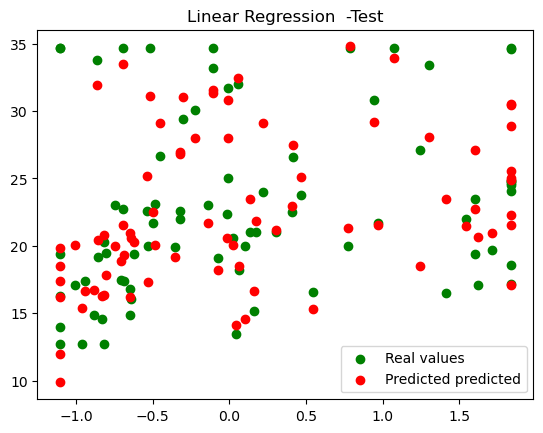

In [ ]:
# to build a dataframe
import pandas as pd
#to split the data into training and testing data
from sklearn.model_selection import train_test_split
#scaling the data is recommended in linear regression, as we dont want one value to dominate
from sklearn.preprocessing import StandardScaler
#this is used to handle the outliners
from scipy.stats.mstats import winsorize
#this calls the mean squared error that tells you how close the linear regression line is the the points
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
#does the model selection for us
from sklearn.linear_model import BayesianRidge
#to do the plot in the end
import matplotlib.pyplot as plt

# this is the file path I have saved the Boston Housing dataset
#in linear regression


file_path = r"C:\Users\Nikaela\Documents\GitHub\SFML_Project\code\question_3\data\archive (1)\HousingData.csv"


# Read the data from CSV file to  a DataFrame
Bostondf = pd.read_csv(file_path)

# The dicription in kaggle.com said there ware missing values, so I am dropping their rows
Bostondf = Bostondf.dropna()  

# I printed the loaded dataset the first time just to see if it was done correctly
#print(Bostondf.head())


# the outliners were mentioned as a challange in the description in the dataset
# taken from official documentation https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.winsorize.html
winsor_columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
for column in winsor_columns:
    Bostondf[column] = winsorize(Bostondf[column], limits=[0.1, 0.1])
    
Bostondf_sorted = Bostondf.sort_index()
# Split the data into features (X) and target (y)
#MEDV: Median value of owner-occupied homes in $1000s (the target variable).
# everything else will be the feature matrix
X = Bostondf_sorted.drop('MEDV', axis=1)
y = Bostondf_sorted['MEDV']

# Split the data into training ,validation, test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


# Scale the input features using StandardScaler, this is done so not one value does not dominate the results
#transform scales the test data with  the same mean and standard deviation computed from the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)
# Build a linear regression model with Bayesian inference
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html
# to explain what it does,  BayesianRidge() used Bayesian inference to calculate  the coefficients of the model
bayesian_lin_reg = BayesianRidge()
bayesian_lin_reg.fit(X_train_scaled, y_train)

# Make predictions using the trained model
y_pred = bayesian_lin_reg.predict(X_test_scaled)

# Evaluate the model by seeing how close actual values are to predicted values
#calculates the average of the squares of the errors, this will give more weight to  large errors
mse = mean_squared_error(y_test, y_pred)
print('Training set - Mean squared error:', mse)

# Compute mean absolute error
#only difference from above is that we trat all errors equaly
mae = mean_absolute_error(y_test, y_pred)
print('Training set -Mean absolute error:', mae)

# Compute R-squared error
r2 = r2_score(y_test, y_pred)
print('Training set - R-squared:', r2)

#Now, we are going to implement everything from above using the validation set, not the training set
# Make predictions on the validation set
y_validation_pred = bayesian_lin_reg.predict(X_validation_scaled)

# Evaluate the model on the validation set
validation_mse = mean_squared_error(y_validation, y_validation_pred)
validation_mae = mean_absolute_error(y_validation, y_validation_pred)
validation_r2 = r2_score(y_validation, y_validation_pred)

print('Validation set - Mean squared error:', validation_mse)
print('Validation set - Mean absolute error:',  validation_mae)
print('Validation set - R-squared:', validation_r2)

# Plot the difference between the real and predicted values for test set
#I randomly choose to take values from the eighth column
#that is because x and y needed to be of the same siwe
plt.scatter(X_test_scaled[:, 7], y_test, color='green', label='Real values')
plt.scatter(X_test_scaled[:, 7], y_pred, color='red', label='Predicted predicted')
plt.title('Linear Regression  -Test')
plt.legend()
plt.show()

In [ ]:
#Requirements for loading the libraries
# !pip install pandas
# !pip install scikit-learn
# !pip install scipy
# !pip install matplotlib
# !pip install scikit-optimize
# !pip install numpy


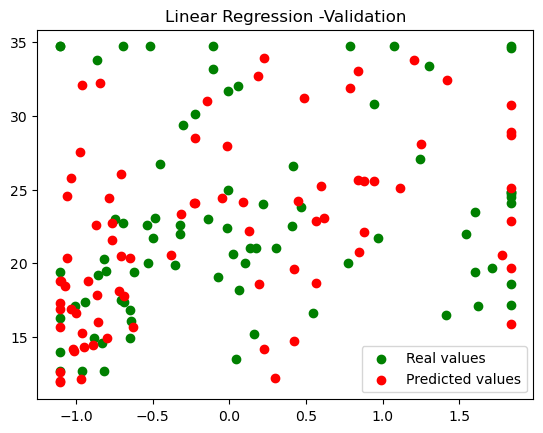

In [ ]:
# Plot the difference between the real and predicted values for validation set
#I randomly choose to take values from the eigth column
plt.scatter(X_test_scaled[:, 7], y_test, color='green', label='Real values')
plt.scatter(X_validation_scaled[:, 7], y_validation_pred, color='red', label='Predicted values')
plt.title('Linear Regression -Validation')
plt.legend()
plt.show()

## Cross-validation for model selection in linear regression
Cross-validation is a technique used to assess how well a model will generalize to new data. For  model selection in linear regression, we can use cross-validation by providing an estimate of the out-of-sample error.[6] This method usially prevents overfitting, so I have an expectation that the results would be better than when using bayesian inference. 

The code is implemented in the same way as the first example until the scaling. I built a linear regression model using LinearRegression from scikit-learn library. Then I perform 5-fold cross-validation on the linear regression model using cross_val_score from scikit-learn. In 5-fold cross-validation, the original sample, so the x-scaled  is randomly seperated  into 5 equal sized folds. The model is then trained on some of the folds and evaluated on the remaining folds.[6]  The cross-validation scores are then used  to get mean squared error scores, and their mean and standard deviation are calculated. I also choose to calcualte the same error metrics  from the first code:  mean squared error, mean absolute error, and R-squared, for both validation and traing set. The mean of the cross validation scores is the average performance of the model for all folds. With a value of 7.66, we can say it is preforming well.The plot is the same as the one in the first code example.
Here is an overview of the results: 
| Metric                               | Value               |
|--------------------------------------|---------------------|
| Cross-validation scores              | [8.28238872, 6.84189091, 8.48456817, 7.32914628, 7.39500273] |
| Mean squared error (mean)            | 7.666599361819953   |
| Validation set - Mean squared error  | 7.879569593989705   |
| Validation set - Mean absolute error | 2.129859173888019   |
| Validation set - R-squared           | 0.7941088112791642  |
| Test set - Mean squared error        | 13.564601715273897  |
| Test set - Mean absolute error       | 2.5198098141283034  |
| Test set - R-squared                 | 0.674460667126381   |



From the results, we can say that it does appear to preform better that the example above. As we know, in bayesian we are using prior knowladge about the input values (parameters) to get a better model. In cross-validation we split the data into 5 sunsets and train and evaluate on them. This helps avoid overfitting, which tend to happen on complex datasets like the Boston housing one.


Cross-validation scores: [8.28238872 6.84189091 8.48456817 7.32914628 7.39500273]
Mean squared error (mean): 7.666599361819953
Validation set - Mean squared error: 7.879569593989705
Validation set - Mean absolute error: 2.129859173888019
Validation set - R-squared: 0.8247312009320446
Test set - Mean squared error: 13.564601715273897
Test set - Mean absolute error: 2.5198098141283034
Test set - R-squared: 0.674460667126381


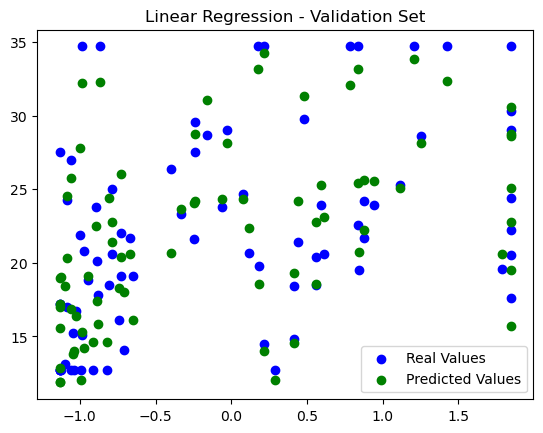

In [ ]:
# to build a dataframe
import pandas as pd
#to split the data into training and testing data and the cross validation score
from sklearn.model_selection import train_test_split, cross_val_score
#scaling the data is recommended in linear regression, as we dont want one value to dominate
from sklearn.preprocessing import StandardScaler
#this is used to handle the outliners
from scipy.stats.mstats import winsorize
#this calls the mean squared error that tells you how close the linear regression line is the the points
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
#builds the linear model
from sklearn.linear_model import LinearRegression
#to plot the values
import matplotlib.pyplot as plt
file_path = r"C:\Users\Nikaela\Documents\GitHub\SFML_Project\code\question_3\data\archive (1)\HousingData.csv"
#Everything is the same as before until the spliting of data
# Read the data from the CSV file into a DataFrame
boston_df = pd.read_csv(file_path)

# Drop rows with missing values
boston_df = boston_df.dropna()

# Winsorize outliers in selected columns
columns_to_winsorize = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
for column in columns_to_winsorize:
    boston_df[column] = winsorize(boston_df[column], limits=[0.1, 0.1])

# Split the data into features (X) and target (y)
X = boston_df.drop('MEDV', axis=1)
y = boston_df['MEDV']

# Scale the input features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training, validation, and test sets
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, y_train_validation, test_size=0.25, random_state=42)

# Build a linear regression model
linear_regression = LinearRegression()

# Perform cross-validation for model selection
# As seen in the example given in this link: https://www.statology.org/k-fold-cross-validation-in-python/
#this method automatically splits the data into folds and does the training and testing for me
cv_scores = cross_val_score(linear_regression, X_train_validation, y_train_validation, cv=5, scoring='neg_mean_squared_error')
mse_scores = -cv_scores

# Calculate the mean  of the cross-validation scores
mean = mse_scores.mean()

print('Cross-validation scores:', mse_scores)
print('Mean squared error (mean):', mean)


# Train the model on the entire training set
linear_regression.fit(X_train, y_train)

# Make predictions on the validation set
y_validation_pred = linear_regression.predict(X_validation)

# Evaluate the model on the validation set
validation_mse = mean_squared_error(y_validation, y_validation_pred)
validation_mae = mean_absolute_error(y_validation, y_validation_pred)
validation_r2 = r2_score(y_validation, y_validation_pred)

print('Validation set - Mean squared error:', validation_mse)
print('Validation set - Mean absolute error:', validation_mae)
print('Validation set - R-squared:', validation_r2)

# Make predictions on the test set
y_test_pred = linear_regression.predict(X_test)

# Evaluate the model on the test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('Test set - Mean squared error:', test_mse)
print('Test set - Mean absolute error:', test_mae)
print('Test set - R-squared:', test_r2)

# Plot the difference between the real and predicted values on the validation set
plt.scatter(X_validation[:, 7], y_validation, color='blue', label='Real Values')
plt.scatter(X_validation[:, 7], y_validation_pred, color='green', label='Predicted Values')
plt.title('Linear Regression - Validation Set')
plt.legend()
plt.show()



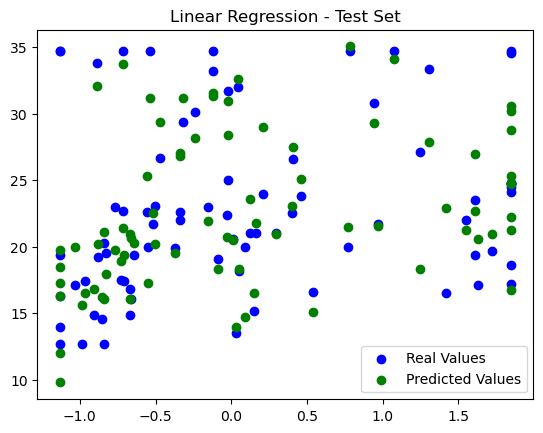

In [ ]:
plt.scatter(X_test[:, 7], y_test, color='blue', label='Real Values')
plt.scatter(X_test[:, 7], y_test_pred, color='green', label='Predicted Values')
plt.title('Linear Regression - Test Set')
plt.legend()
plt.show()

### Stepwise regression for Model selection in Linear regression

Stepwise regression fits regression models by making predictive analysis for the variable. Essentially, we have a predifined condition and based on that we can select the best feature. There are three aproaches: forward, backward, bidirectional.[5] I will try the forward  aproache to see how it  fits my linear model. In the forward aproach we start with a model with no variable and add the ones which based on a criteria fit the best. I predict that the resuls will not be better than my other methods, as stepwise tends to overfit the data as it looks for every possible model in the model space.[5] 

| Metric                               | Value               |
|--------------------------------------|---------------------|
| Validation set - Mean squared error  | 10.475686122934626  |
| Validation set - Mean absolute error | 2.571751100887579   |
| Validation set - R-squared           | 0.7669846170811043  |
| Selected Features                    |'RM''PTRATIO''LSTAT' |
| Test set - Mean squared error        | 14.640030769522427  |
| Test set - Mean absolute error       | 2.8128355874567386  |
| Test set - R-squared                 | 0.6486512505123448  |
| Selected Features                    |'RM''PTRATIO''LSTAT' |


Although we see that is preforms well, cross-validation and bayesian inference out perform this model. However, it is worth noting that using this method we also get some information on the features that inpact the output the most.

Validation set - Mean squared error: 10.475686122934626
Validation set - Mean absolute error: 2.571751100887579
Validation set - R-squared: 0.7669846170811043
Selected Features: ['RM', 'PTRATIO', 'LSTAT']
Test set - Mean squared error: 14.640030769522427
Test set - Mean absolute error: 2.8128355874567386
Test set - R-squared: 0.6486512505123448
Selected Features: ['RM', 'PTRATIO', 'LSTAT']


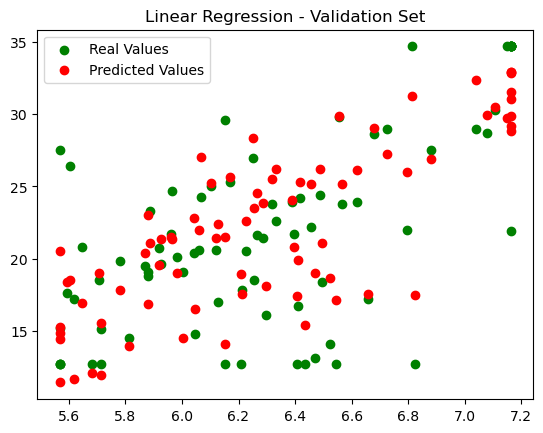

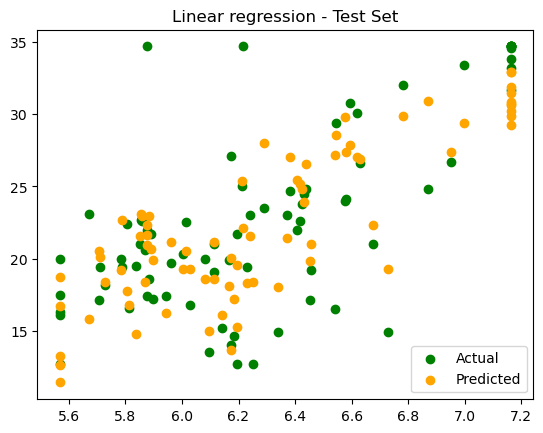

In [ ]:
# to build a dataframe
import pandas as pd
#to split the data into training and testing data
from sklearn.model_selection import train_test_split
#scaling the data is recommended in linear regression, as we dont want one value to dominate
from sklearn.preprocessing import StandardScaler
#this is used to handle the outliners
from scipy.stats.mstats import winsorize
#this calls the mean squared error that tells you how close the linear regression line is the the points
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
#to do the plot in the end
import matplotlib.pyplot as plt
#to do the  forward regression
from sklearn.feature_selection import SequentialFeatureSelector

# this is the file path I have saved the Boston Housing dataset
#in linear regression

file_path = r"C:\Users\Nikaela\Documents\GitHub\SFML_Project\code\question_3\data\archive (1)\HousingData.csv"
#preprocessing is done the same as before
Bostondf = pd.read_csv(file_path)
Bostondf = Bostondf.dropna()
columns_to_winsorize = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
for column in columns_to_winsorize:
    Bostondf[column] = winsorize(Bostondf[column], limits=[0.1, 0.1])
Bostondf_sorted = Bostondf.sort_index()

X = Bostondf_sorted.drop('MEDV', axis=1)
y = Bostondf_sorted['MEDV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

linear_regression = LinearRegression()
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html
#we can use Sequential Feature Selector  to have an estimator that choosed the best feature 
# by adding  or removing based on the cross-validation score of an estimator 
sfs = SequentialFeatureSelector(linear_regression, n_features_to_select=3, direction='forward')
sfs.fit(X_train_scaled, y_train)
#we select the features from the train columns
selected_features = list(X_train.columns[list(sfs.get_support(indices=True))])
#selected x is now for the features (columns) we get from the farward analysis
#we do this for both the train and validation set
X_train_selected = X_train[selected_features]
X_validation_selected = X_validation[selected_features]
X_test_selected = X_test[selected_features]
#we train the linear regression model to fit the selected features
linear_regression.fit(X_train_selected, y_train)

# Make predictions on the validation set
y_validation_pred = linear_regression.predict(X_validation_selected)

# Evaluate the model on the validation set
validation_mse = mean_squared_error(y_validation, y_validation_pred)
validation_mae = mean_absolute_error(y_validation, y_validation_pred)
validation_r2 = r2_score(y_validation, y_validation_pred)

print('Validation set - Mean squared error:', validation_mse)
print('Validation set - Mean absolute error:', validation_mae)
print('Validation set - R-squared:', validation_r2)
print('Selected Features:', selected_features)

# Make predictions on the test set
y_test_pred = linear_regression.predict(X_test_selected)

# Evaluate the model on the test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('Test set - Mean squared error:', test_mse)
print('Test set - Mean absolute error:', test_mae)
print('Test set - R-squared:', test_r2)
print('Selected Features:', selected_features)

# The plotting is the same as the rest of the examples, only the column we use changes
#since i asked it to only select 3 parameters, the 6th coulumn is out of bounds. Therefor I choose the first column
#for plotting
plt.scatter(X_validation_selected.iloc[:, 0], y_validation, color='green', label='Real Values')
plt.scatter(X_validation_selected.iloc[:, 0], y_validation_pred, color='red', label='Predicted Values')
plt.title('Linear Regression - Validation Set')
plt.legend()
plt.show()


plt.scatter(X_test_selected.iloc[:, 0], y_test, color='green', label='Actual')
plt.scatter(X_test_selected.iloc[:, 0], y_test_pred, color='orange', label='Predicted')
plt.title('Linear regression - Test Set')
plt.legend()
plt.show()


## Bayesian optimization for Support Vector Machines

Bayesian inference is not commonly  used in SVM for  model selection.SVM tends to use optimization in order to find the best hyperplane to seperate the data. In orer to do that I will be applying Bayesian Optimization to find the best parameters.Bayesian builds a probabilistic model  and uses it to select the most promising  data points to evaluate. [10]  The good thing about this is that we can find the result without having to evaluate for a long time. Another change made, is that the dataset is going to be synthetic data generated through scipy.stats.

**Support Vector Machines** 

Support vector machines are lerning methods we tend to use for classification. The way we use them is by having a hyperplane, so that all points of one category are in one plane and all points of the other category are in another plane. SVM tries to find the best way to seperate the data, by measuring the distance to points in either category. The closest points (xn) to the plane achieve the margin. They must adhere to this condition:

$Y_n(w^tX_n + b) = 1$
 
So that means we can compute w by only considering the Xn that are part of the vectors. All others will be 0 so they will not contribute.The points that fall exactly on the margin are the Supporting vector. That is expressed in this formula:
![WinSVM.png](question_3/data/WinSVM.png)
<br>
Our vc-dimension corresponds to the amount of parameters that are support vectors ( which arent 0).We have an expectation that he out of sample error is bounded by the expectation of number of SV devided by the number of data points.[9]

![ExpectationEoutSVM.png](question_3/data/ExpectationEoutSVM.png)
<br>
When the data is not ninearly seperable we need to perform a non- linear transformation.

### Synthetic Dataset generator
In order to read the data I read the examples given in the scikit-learn about Generated datasets.  I set the number of parameters to 10 and the number of rows to 50. I call the function make_classification for this. After the data is generated I save it in the SyntheticData file.



In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split



# Generate data  with 500 rows and 10 columns
num_rows = 500
num_columns = 10

#https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification
#we call the make_classification to generate linearly separable data
X, y = make_classification(
    n_samples=num_rows,
    n_features=num_columns,
    n_informative=num_columns,  # All features need to be  informative
    n_redundant=0,  # No redundant features 
    #we are doing this so that the data is linearly seperable
    n_clusters_per_class=1,  # Each class forms a single cluster
    
)



In [ ]:
import pandas as pd
# Now we want to create a dataset that builds column for every feature and the target
#first i make a list with names for the features 
features =["f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8"]
#creating an  empty dictionary for values
empty_dict={}
#for look to iterate through every feature, use k as index
for k, name in enumerate(features):
    #the empty dictionary naw has name that contains the name of features
    empty_dict[name] = X[:, k]
    # we add the y with key name target
    empty_dict["target"] = y

    # creating a dataFrame  using the dictionary 
    # key-value pair in this case is the  column with key the name 
    #and its  values are the column values.
generated_data = pd.DataFrame(empty_dict)

# Save the dataset to a  the empty file I ceated for it 
file_path = r"C:\Users\Nikaela\Documents\GitHub\SFML_Project\code\question_3\data\archive (1)\GeneratedData.csv"
generated_data.to_csv(file_path, index=False)
#this was just for the first time i ran the code and wanted confirmation if data transfer was successful
if pd.read_csv(file_path).shape == generated_data.shape:
    print("Data transfer successful!")
else:
    print("Data transfer failed!")

Data transfer successful!


### Support vector machine with bayesian optimization 
Now that the code is generated and save in the file, we do the optimization and check the results.
The results show: 

- C:  1000000.0  shows that the decision boundary will be more complex as the value is quite high.
- coef0: this is  constant term in the polynomial and sigmoid kernel functions. In this case, it is set to 1.
- degree:  degree of the polynomial kernel function. Our results show 2 that indicates a quadratic polynomial kernel.
- gamma: 0.05137159597860008 is relatively high and  indicates a more complex decision boundary. gamma basically shows how the training data impacts the result.
- kernel: the 'poly' kernel is selected, which means our model choose  a polynomial kernel.


- The test accuracy of 0.86 means that the SVM   achieved an accuracy of 86% on the test set.
Overall we can say that the the hyperparametes achieved from the choosen polynomial kernel perform well and with an accuracy of 86%. This means it can predict well in unseen data.
However one thing to note is that running this code took a really long time.




In [ ]:
#to load the files 
import pandas as pd
#to build the plots
import matplotlib.pyplot as plt
#to apply transformation to linear data
import numpy as np
#to build svm 
from sklearn.svm import SVC
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split
import skopt
# Read the data from the file we saved the generated data in
file_path = r"C:\Users\Nikaela\Documents\GitHub\SFML_Project\code\question_3\data\archive (1)\GeneratedData.csv"
generated_data = pd.read_csv(file_path)

# # we alredy set the column names and set one as target = y
# #seperate the data into target and the rest are features
X_data = generated_data.drop('target', axis=1)
y_data = generated_data['target']

#split to train test and validate
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=42)



# SVC is already a class from scikit-learn, so I call it to  represents the model
#SVM classifier
svm = SVC()

# defining  the search space for the hyperparameters of SVM
# similar to this code https://scikit-learn.org/stable/modules/grid_search.html as I took it as an example
# I also read this for an more detailed explenation on each parameter: 
#https://ekamperi.github.io/machine%20learning/2021/05/08/bayesian-optimization.html
param_space = {
    'C': (1e-6, 1e+6, 'log-uniform'), # C is a regularization parameter, we want it to stay between between 1e-6 and 1e+6 on a logarithmic scale
    'gamma': (1e-6, 1e+1, 'log-uniform'), #gamma defines how each training example effect SVM
    'kernel': ['linear', 'poly', 'rbf'], #we want to decide which kernel to use 
    # i included all  linear, polynomial and radial basis function kernels 
    'degree': (1, 3),
    'coef0': (0, 1),
}

# Bayesian optimization
# BayesSearchCV  takes svm model to tun, param_space contains the range of values each hyperparameter can take
# n_iter=50 should iterate 50 times, cv=3 have three cross validation folds
optimization = BayesSearchCV(svm,param_space,n_iter=50,cv=3,n_jobs=-1)
# here we perform the optimization for subset
optimization.fit(X_train_subset,y_train_subset)

# showing the best parametes we found
print("Best hyperparameters:", optimization.best_params_)

# model performance evaluation
test_accuracy = optimization.score(X_test_subset,y_test_subset)
print("Test accuracy:", test_accuracy)



Best hyperparameters: OrderedDict([('C', 1000000.0), ('coef0', 1), ('degree', 2), ('gamma', 0.05137159597860008), ('kernel', 'poly')])
Test accuracy: 0.86


This is the same example as before, only now we are getting results for a smaller sample of the data. I do this, because the original code takes a long time to run and we can assume it will be even longer for a grid search. Therefor, if I want to compare the two methods I need to have the same parameter space. 
As we can see a much lower c value and gamma, so the boundary is less complex. Accuracy is 90%, so quite high. But we can relate that to the relatively small number of samples. The degree is 3, so the polynomial kernel function will be cubic. That allows for complex and non-linear data.

| Parameter  | Value |
|------------|------ |
| C          | 1     |
|coef0       | 1     |
| degree     | 3     |
| gamma      | 0.09  |
|kernel      | poly  |
| accuracy   | 0.9   |

In [ ]:
import pandas as pd
#to build the plots
import matplotlib.pyplot as plt
#to apply transformation to linear data
import numpy as np
#to build svm 
from sklearn.svm import SVC
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split
import skopt

# Read the data from the file we saved the generated data in
file_path = r"C:\Users\Nikaela\Documents\GitHub\SFML_Project\code\question_3\data\archive (1)\GeneratedData.csv"
generated_data = pd.read_csv(file_path)

# we alredy set the column names and set one as target = y
# seperate the data into target and the rest are features
# X_data = generated_data.drop('target', axis=1)
# y_data = generated_data['target']

# Subseting  the data to a smaller portion
subset_size = 100  

# taking 100 samples from generated data
subset_data = generated_data.sample(n=subset_size, random_state=42)
#spliting the data we took to features and target
X_data_subset = subset_data.drop('target', axis=1)
y_data_subset = subset_data['target']

# Split the subset into train, test, and validation sets
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X_data_subset, y_data_subset, test_size=0.2, random_state=42)
X_train_subset, X_validation_subset, y_train_subset, y_validation_subset = train_test_split(X_train_subset, y_train_subset, test_size=0.25, random_state=42)

# SVC is already a class from scikit-learn, so I call it to  represents the model
#SVM classifier
svm = SVC()

# defining  the search space for the hyperparameters of SVM
# similar to this code https://scikit-learn.org/stable/modules/grid_search.html as I took it as an example
# I also read this for an more detailed explenation on each parameter: 
#https://ekamperi.github.io/machine%20learning/2021/05/08/bayesian-optimization.html

param_space = {
     'C': [1, 10, 100, 1000], #all the parameters are simple, so the runtime is shorter
    'gamma': [0.001 , 0.01], 
    'kernel': ['linear' , 'poly' , 'rbf'],
    'degree': [1, 2, 3],
    'coef0': [0, 1]
}

# Bayesian optimization
# BayesSearchCV  takes svm model to tun, param_space contains the range of values each hyperparameter can take
# n_iter=50 should iterate 50 times, cv=3 have three cross validation folds
optimization = BayesSearchCV(svm,param_space,n_iter=50,cv=3,n_jobs=-1)
# here we perform the optimization for subset
optimization.fit(X_train_subset,y_train_subset)

# showing the best parametes we found
print("Best hyperparameters:", optimization.best_params_)

# model performance evaluation
test_accuracy = optimization.score(X_test_subset,y_test_subset)
print("Test accuracy:", test_accuracy)



C:\Users\Nikaela\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Nikaela\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Nikaela\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Nikaela\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Nikaela\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best hyperparameters: OrderedDict([('C', 1), ('coef0', 1), ('degree', 3), ('gamma', 0.009950852809583858), ('kernel', 'poly')])
Test accuracy: 0.9


C:\Users\Nikaela\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


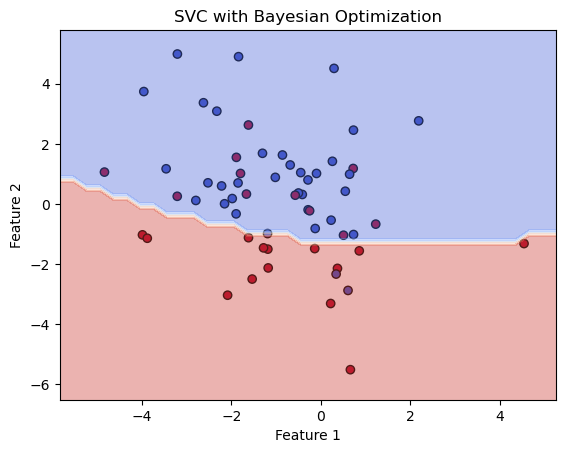

In [ ]:

# https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html
# we are taking the first 2 features from the subset
X_train_subset_2d = X_train_subset.iloc[:, :2]

# since we now have the optimized parameters we train our model to fit it
svm_model = SVC(**optimization.best_params_)
svm_model.fit(X_train_subset_2d, y_train_subset)

# https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html
# meshgrid to plot the coordinates of the decision boundary
# finding the min and max values of the features and building a grid of points using np.meshgrid.
x_min, x_max = X_train_subset_2d.iloc[:, 0].min() - 1, X_train_subset_2d.iloc[:, 0].max() + 1
y_min, y_max = X_train_subset_2d.iloc[:, 1].min() - 1, X_train_subset_2d.iloc[:, 1].max() + 1
X_plot, Y_plot = np.meshgrid(np.arange(x_min, x_max, 0.3), np.arange(y_min, y_max, 0.3))
# setting smoothness to 0.3
# reshaping predictions to match the shape of the meshgrid
Z = svm_model.predict(np.c_[X_plot.ravel(), Y_plot.ravel()])
Z = Z.reshape(X_plot.shape)

# Plot the data points
plt.scatter(X_train_subset_2d.iloc[:, 0], X_train_subset_2d.iloc[:, 1], c=y_train_subset, cmap='coolwarm', edgecolors='k')

# Plot the decision boundary
plt.contourf(X_plot, Y_plot, Z, alpha=0.4, cmap='coolwarm')

# Set the labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVC with Bayesian Optimization')


# Show the plot
plt.show()


### Grid Search
 GridSearchCV exhaustively considers all parameter combinations [11] , that is why is quite exstencive and lates a long time to run. From the results:
| Parameter  | Value |
|------------|------ |
| C          | 10    |
|coef0       | 0     |
| degree     | 1     |
| gamma      | 0.01  |
|kernel      | poly  |
| accuracy   | 0.9   |

The missclassificatioin penalty is higher, the degree is lower. That means that is no calable of capturing complex relationships. The accuracy stays the same as when using the bayesian optimization.

In [ ]:
import pandas as pd
#to build the plots
import matplotlib.pyplot as plt
#to apply transformation to linear data
import numpy as np
#to build svm 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


# Read the data from the file we saved the generated data in
file_path = r"C:\Users\Nikaela\Documents\GitHub\SFML_Project\code\question_3\data\archive (1)\GeneratedData.csv"
generated_data = pd.read_csv(file_path)

# we alredy set the column names and set one as target = y
# seperate the data into target and the rest are features
X_data = generated_data.drop('target', axis=1)
y_data = generated_data['target']

# Subset the data to a smaller portion
subset_size = 100  # Choose the desired subset size

# Randomly select subset_size samples from the dataset
subset_data = generated_data.sample(n=subset_size, random_state=42)

# Separate the subset into features and target
X_data_subset = subset_data.drop('target', axis=1)
y_data_subset = subset_data['target']

# Split the subset into train, test, and validation sets
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X_data_subset, y_data_subset, test_size=0.2, random_state=42)
X_train_subset, X_validation_subset, y_train_subset, y_validation_subset = train_test_split(X_train_subset, y_train_subset, test_size=0.25, random_state=42)

# SVC is already a class from scikit-learn, so I call it to  represents the model
#SVM classifier
svm = SVC()

 # defining  the search space for the hyperparameters of SVM
# similar to this code https://scikit-learn.org/stable/modules/grid_search.html as I took it as an example
# I also read this for an more detailed explenation on each parameter: 
#https://ekamperi.github.io/machine%20learning/2021/05/08/bayesian-optimization.html
#the original parameter space used in bayesian took a lot of time, so i switched to something simpler
param_space = {
     'C': [1, 10, 100, 1000],
    'gamma': [0.001 , 0.01],
    'kernel': ['linear' , 'poly' , 'rbf'],
    'degree': [1, 2, 3],
    'coef0': [0, 1]
}

grid_search = GridSearchCV(svm, param_space, cv=3)
grid_search.fit(X_train_subset, y_train_subset)

print("Best hyperparameters:", grid_search.best_params_)

test_accuracy = grid_search.score(X_test_subset, y_test_subset)

print("Test accuracy:", test_accuracy)


Best hyperparameters: {'C': 1, 'coef0': 1, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}
Test accuracy: 0.9


C:\Users\Nikaela\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


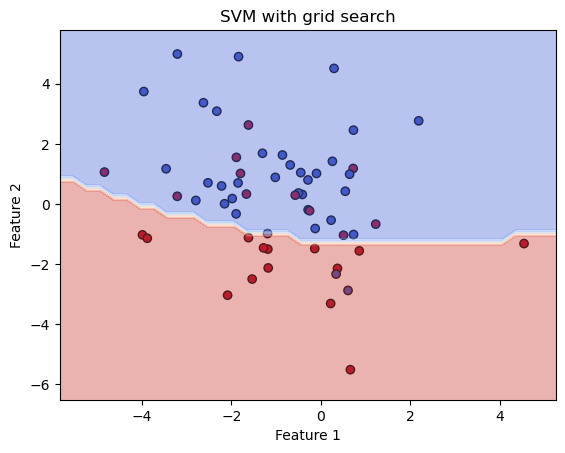

In [ ]:
# https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html
# we are taking the first 2 features from the subset
X_train_subset_2d = X_train_subset.iloc[:, :2]

# since we now have the optimized parameters we train our model to fit it

svm_model = SVC(**grid_search.best_params_)
svm_model.fit(X_train_subset_2d, y_train_subset)

# https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html
# meshgrid to plot the coordinates of the decision boundary
# finding the min and max values of the features and building a grid of points using np.meshgrid.
x_min, x_max = X_train_subset_2d.iloc[:, 0].min() - 1, X_train_subset_2d.iloc[:, 0].max() + 1
y_min, y_max = X_train_subset_2d.iloc[:, 1].min() - 1, X_train_subset_2d.iloc[:, 1].max() + 1
X_plot, Y_plot = np.meshgrid(np.arange(x_min, x_max, 0.3), np.arange(y_min, y_max, 0.3))
# setting smoothness to 0.3
# reshaping predictions to match the shape of the meshgrid
Z = svm_model.predict(np.c_[X_plot.ravel(), Y_plot.ravel()])
Z = Z.reshape(X_plot.shape)

# Plot the data points
plt.scatter(X_train_subset_2d.iloc[:, 0], X_train_subset_2d.iloc[:, 1], c=y_train_subset, cmap='coolwarm', edgecolors='k')

# Plot the decision boundary
plt.contourf(X_plot, Y_plot, Z, alpha=0.4, cmap='coolwarm')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM with grid search')



plt.show()


### Conclusions
In conclusion, using Bayesian Inference for model selection in linear regression, gives really good results. However, it is also prone to overfitting, which can be a problem. Cross-validation performs  better as it tends to avoid overfitting and performs better in model selection. 
When using Bayesian  optimisation versus grid search, the accuracy for the data is 90% for both subsets, however there are some differences. Bayesian optimization has a higher degree, there for it is able to handle more complex data easier. The C parameter is also lower, this means that  a larger C indicates a stricter penalty, so there would be a  more complex decision boundary. A complex boundary can be better for interpreting non-linear data like ours but also tends to overfit. 

## References
- [1]: Wikipedia contributors. (2023, May 20). Bayesian inference. In Wikipedia, The Free Encyclopedia. Retrieved 20:18, May 2, 2023, from https://en.wikipedia.org/w/index.php?title=Bayesian_inference&oldid=1155845921
- [2]: Libin, P. (2022). Bayesian learning. In Statistical Foundations of Machine Learning.
- [3]: Libin, P. (2022). The linear model, error, and noise. In Statistical Foundations of Machine Learning.
- [4]: M. Concepcion Ausin.Bayesian Inference Chapter 9. Linear models and regression.
- [5]: Wikipedia contributors. (2023, January 25). Stepwise regression. In Wikipedia, The Free Encyclopedia. Retrieved 11:40, May 4, 2023, from https://en.wikipedia.org/w/index.php?title=Stepwise_regression&oldid=1135580725
- [6]: Wikipedia contributors. (2023, May 21). Cross-validation (statistics). In Wikipedia, The Free Encyclopedia. Retrieved 15:24, May 4 2023, from https://en.wikipedia.org/w/index.php?title=Cross-validation_(statistics)&oldid=1156093433
- [7]: Abu-Mostafa, Y. S., Magdon-Ismail, M., & Lin, H. (2012). Learning from Data: A Short Course.
- [8]: Wikipedia contributors. (2023, May 8). Linear regression. In Wikipedia, The Free Encyclopedia. Retrieved 10:03, May 10, 2023, from https://en.wikipedia.org/w/index.php?title=Linear_regression&oldid=1153729683
- [9]: Libin, P. (2022). Validation - Support Vector Machines. In Statistical Foundations of Machine Learning.
- [10]: Amy @GrabNGoInfo. (2023, May 22). Support Vector Machine (SVM) Hyperparameter Tuning In Python. Medium. https://medium.com/grabngoinfo/support-vector-machine-svm-hyperparameter-tuning-in-python-a65586289bcb
- [11]: 3.2. Tuning the hyper-parameters of an estimator. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/grid_search.html
